# **Ensemble Techniques Project - EasyVisa**

- Student: Alexey Tyurin
- Group: Oct'22 C Sun - MLS Grp B
- Batch: PGP-DSBA-UTA-OCT22-C
- Date: 4/2/2023-4/14/2023

## Context:

Business communities in the United States are facing high demand for human resources, but one of the constant challenges is identifying and attracting the right talent, which is perhaps the most important element in remaining competitive. Companies in the United States look for hard-working, talented, and qualified individuals both locally as well as abroad.

The Immigration and Nationality Act (INA) of the US permits foreign workers to come to the United States to work on either a temporary or permanent basis. The act also protects US workers against adverse impacts on their wages or working conditions by ensuring US employers' compliance with statutory requirements when they hire foreign workers to fill workforce shortages. The immigration programs are administered by the Office of Foreign Labor Certification (OFLC).

OFLC processes job certification applications for employers seeking to bring foreign workers into the United States and grants certifications in those cases where employers can demonstrate that there are not sufficient US workers available to perform the work at wages that meet or exceed the wage paid for the occupation in the area of intended employment.

## Objective:

In FY 2016, the OFLC processed 775,979 employer applications for 1,699,957 positions for temporary and permanent labor certifications. This was a nine percent increase in the overall number of processed applications from the previous year. The process of reviewing every case is becoming a tedious task as the number of applicants is increasing every year.

The increasing number of applicants every year calls for a Machine Learning based solution that can help in shortlisting the candidates having higher chances of VISA approval. OFLC has hired your firm EasyVisa for data-driven solutions. You as a data scientist have to analyze the data provided and, with the help of a classification model:

* Facilitate the process of visa approvals.
* Recommend a suitable profile for the applicants for whom the visa should be certified or denied based on the drivers that significantly influence the case status.

## Data Description

The data contains the different attributes of the employee and the employer. The detailed data dictionary is given below.

* `case_id`: ID of each visa application
* `continent`: Information of continent the employee
* `education_of_employee`: Information of education of the employee
* `has_job_experience`: Does the employee has any job experience? Y= Yes; N = No
* `requires_job_training`: Does the employee require any job training? Y = Yes; N = No 
* `no_of_employees`: Number of employees in the employer's company
* `yr_of_estab`: Year in which the employer's company was established
* `region_of_employment`: Information of foreign worker's intended region of employment in the US.
* `prevailing_wage`:  Average wage paid to similarly employed workers in a specific occupation in the area of intended employment. The purpose of the prevailing wage is to ensure that the foreign worker is not underpaid compared to other workers offering the same or similar service in the same area of employment. 
* `unit_of_wage`: Unit of prevailing wage. Values include Hourly, Weekly, Monthly, and Yearly.
* `full_time_position`: Is the position of work full-time? Y = Full Time Position; N = Part Time Position
* `case_status`:  Flag indicating if the Visa was certified or denied

## Importing necessary libraries and data

### Importing necessary libraries

In [1]:
# Libraries to help with reading and manipulating data
import numpy as np
import pandas as pd

# libaries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Library to split data
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, export_text 
from sklearn import tree

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import (GradientBoostingClassifier,
                              AdaBoostClassifier,
                              StackingClassifier)
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer

#from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import (accuracy_score,
                             precision_score,
                             recall_score,
                             f1_score,
                             roc_auc_score)
from sklearn.utils.class_weight import compute_class_weight

import scipy.stats as stats
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')

### Reading the dataset

In [2]:
data=pd.read_csv('EasyVisa.csv')

In [3]:
# copying data to another varaible to avoid any changes to original data
df = data.copy()

## User-defined functions

### Combined boxplot and histogram

In [4]:
# functiom to create combined boxplot and histogram
def histogram_boxplot(data, feature, figsize=(10, 5), fmt='{:.1f}', rotation=0,
                      title=None, kde=True, bins=None, step=None, xlabel=None):
    x = data[feature]
    colors = sns.color_palette("Spectral")
    title = title if title else f'Distribution for `{feature}` column'

    x_min, x_max = x.min(), x.max()

    if (bins == None) & (step == None):
        bins = int(3 * np.log(x.nunique())) + 2
    elif bins == None:
        x_min = step * round(x_min / step, 0)
        x_max = step * round(x_max / step, 0) + step
        bins = int((x_max - x_min) / step)

    bw = (x_max - x_min) / bins

    fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=figsize,
                           gridspec_kw={"height_ratios": (0.3, 0.7)})

    plt.suptitle(title, fontsize=16)
    box = sns.boxplot(data=data, x=feature, ax=ax[0], showmeans=True, color=colors[1])
    hist = sns.histplot(data=data, x=feature, kde=kde, ax=ax[1], color=colors[4], bins=bins)

    ax[0].set_xlabel('')
    ax[1].axvline(x.median(), color="grey", linestyle="-")
    ax[1].axvline(x.mean(), color="darkgreen", linestyle="--")
    ax[1].set_ylabel('Number of cases', fontsize=12)
    if xlabel: ax[1].set_xlabel(xlabel, fontsize=12)

    labels = [fmt.format(x) for x in np.arange(x_min, x_max, bw)]
    ticks =  [x+bw/2 for x in np.arange(x_min, x_max, bw)]

    ax[1].set_xticks(ticks)
    ax[1].set_xticklabels(labels, rotation=rotation)

    plt.show();

### Labeled barplots

In [5]:
# function to create labeled barplots
def labeled_barplot(data, feature, perc=False, n=None, percfmt="{:.1f}%", rnd=0,
                    figsize=(10, 5), xlabel=None, xlo=0, title=None, sort=True, 
                    orient='h'):
    """
    Barplot with percentage at the top

    data: dataframe
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    figsize: size of figure (default (10, 5))
    xlabel: label for x axis
    """

    fig, ax = plt.subplots(figsize=figsize)
    plt.xticks(rotation=xlo, fontsize=14)
    if orient == 'h':
      sns.countplot(data=data, x=feature, palette="Paired",
                    order=data[feature].value_counts().index[:n] if sort else None)
    else:
      sns.countplot(data=data, y=feature, palette="Paired",
                    order=data[feature].value_counts().index[:n] if sort else None)

    # draw lables
    for p in ax.patches:
      if orient == 'h':
        if perc == True:
          label = percfmt.format(100 * p.get_height() / data.shape[0])
        else:
          label = p.get_height()
        ax.annotate(label, (p.get_x() + p.get_width() / 2, p.get_height()),
                    ha="center", va="center", size=11, xytext=(0, 5),
                    textcoords="offset points")
        ax.set_ylabel('Number of cases', fontsize=14)
        if xlabel: ax.set_xlabel(xlabel, fontsize=14)
      else:
        if perc == True:
          label = percfmt.format(100 * p.get_width() / data.shape[0])
        else:
          label = p.get_width()
        ax.annotate(label, (p.get_width(), p.get_y() + p.get_height() / 2),
                    ha="center", va="center", size=11, xytext=(20, 0),
                    textcoords="offset points")
        ax.set_xlabel('Number of cases', fontsize=14)
        if xlabel: ax.set_ylabel(xlabel, fontsize=14)

    if title: plt.title(title, fontsize=16)
    else: plt.title(f'Distribution for `{feature}` column', fontsize=16)

    plt.show()

### Stacked barplot

In [6]:
def stacked_barplot(data, predictor, target, rotation=0):
    """
    Print the category counts and plot a stacked bar chart

    data: dataframe
    predictor: independent variable
    target: target variable
    """
    count = data[predictor].nunique()
    sorter = data[target].value_counts().index[-1]
    tab1 = pd.crosstab(data[predictor], data[target], margins=True).sort_values(
        by=sorter, ascending=False
    )
    print(tab1)
    print("-" * 120)
    tab = pd.crosstab(data[predictor], data[target], normalize="index").sort_values(
        by=sorter, ascending=False
    )
    ax = tab.plot(kind="bar", stacked=True, figsize=(count + 5, 5))
    ax.set_xticklabels(ax.get_xticklabels(),rotation=rotation)
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    plt.show()

### Distributions wrt target

In [7]:
def distribution_plot_wrt_target(data, predictor, target):

    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    target_uniq = data[target].unique()

    axs[0, 0].set_title("Distribution of target for target=" + str(target_uniq[0]))
    sns.histplot(
        data=data[data[target] == target_uniq[0]],
        x=predictor,
        kde=True,
        ax=axs[0, 0],
        color="teal",
        stat="density",
    )

    axs[0, 1].set_title("Distribution of target for target=" + str(target_uniq[1]))
    sns.histplot(
        data=data[data[target] == target_uniq[1]],
        x=predictor,
        kde=True,
        ax=axs[0, 1],
        color="orange",
        stat="density",
    )

    axs[1, 0].set_title("Boxplot w.r.t target")
    sns.boxplot(data=data, x=target, y=predictor, ax=axs[1, 0], palette="gist_rainbow")

    axs[1, 1].set_title("Boxplot (without outliers) w.r.t target")
    sns.boxplot(
        data=data,
        x=target,
        y=predictor,
        ax=axs[1, 1],
        showfliers=False,
        palette="gist_rainbow",
    )

    plt.tight_layout()
    plt.show()

### Model Performance - compute different metrics and visualize results

In [8]:
# Let's define function to provide metric scores (accuracy, recall, precision, etc.) 
# on train and test set and a function to show confusion matrix 
# so that we do not have use the same code repetitively while evaluating models.
# defining a function to compute different metrics to check performance of 
# a classification model built using sklearn

def specificity_score(y_true, y_pred):
  tn, fp, fn, tp = confusion_matrix(y_true, y_pred).flatten()
  return (tn)/(tn+fp)

def npv_score(y_true, y_pred):
  tn, fp, fn, tp = confusion_matrix(y_true, y_pred).flatten()
  return (tn)/(tn+fn)

def model_performance(model, X_train, y_train, X_test, y_test, verbose=True):
  p_train = model.predict(X_train).astype(bool)
  p_test = model.predict(X_test).astype(bool)
  y_train = np.array(y_train).astype(bool)
  y_test = np.array(y_test).astype(bool)

  cm_train = confusion_matrix(y_train, p_train)
  cm_test = confusion_matrix(y_test, p_test)
  lab_train = np.asarray([["{0:,.0f}".format(item) + 
                           "\n{0:.2%}".format(item / cm_train.flatten().sum())] 
                          for item in cm_train.flatten()]).reshape(2, 2)
  lab_test  = np.asarray([["{0:,.0f}".format(item) + 
                           "\n{0:.2%}".format(item / cm_test.flatten().sum())] 
                          for item in cm_test.flatten()]).reshape(2, 2)

  df_perf = pd.DataFrame({'Accuracy':    [accuracy_score(y_train, p_train), 
                                          accuracy_score(y_test, p_test)],
                          'Precision':   [precision_score(y_train, p_train), 
                                          precision_score(y_test, p_test)],
                          'Recall':      [recall_score(y_train, p_train), 
                                          recall_score(y_test, p_test)],
                          'NPV':         [npv_score(y_train, p_train), 
                                          npv_score(y_test, p_test)],
                          'Specificity': [specificity_score(y_train, p_train), 
                                          specificity_score(y_test, p_test)],
                          'F1':          [f1_score(y_train, p_train), 
                                          f1_score(y_test, p_test)]},
                         index=['Train', 'Test'])

  if verbose:
    fig, ax = plt.subplots(ncols = 2, nrows = 1, figsize=(9, 3))

    sns.heatmap(cm_train, annot=lab_train, fmt="", ax=ax[0], annot_kws = {"size": 10})
    sns.heatmap(cm_test, annot=lab_test, fmt="", ax=ax[1], annot_kws = {"size": 10})
    ax[0].set_title('Training dataset', fontsize=10)
    ax[0].set_xlabel('Predicted label', fontsize=10)
    ax[0].set_ylabel('True label', fontsize=10)
    ax[1].set_title('Testing dataset', fontsize=10)
    ax[1].set_xlabel('Predicted label', fontsize=10)
    ax[1].set_ylabel('True label', fontsize=10)
    plt.show();

    display(df_perf.style.set_table_styles([dict(selector="th", 
                                                 props=[('max-width', 
                                                         '75px')])]).format('{:.2%}'))
  
  return df_perf

## Data Overview

- [x] Observations
- [x] Sanity checks

### View the first and last 5 rows of the dataset

In [9]:
df.head()

case_id continent education_of_employee has_job_experience  \
0  EZYV01      Asia           High School                  N   
1  EZYV02      Asia              Master's                  Y   
2  EZYV03      Asia            Bachelor's                  N   
3  EZYV04      Asia            Bachelor's                  N   
4  EZYV05    Africa              Master's                  Y   

  requires_job_training  no_of_employees  yr_of_estab region_of_employment  \
0                     N            14513         2007                 West   
1                     N             2412         2002            Northeast   
2                     Y            44444         2008                 West   
3                     N               98         1897                 West   
4                     N             1082         2005                South   

   prevailing_wage unit_of_wage full_time_position case_status  
0         592.2029         Hour                  Y      Denied  
1       83425.6500         Year                  Y   Certified  
2      122996.8600         Year                  Y      Denied  
3       83434.0300         Year                  Y      Denied  
4      149907.3900         Year                  Y   Certified

In [10]:
df.tail()

case_id continent education_of_employee has_job_experience  \
25475  EZYV25476      Asia            Bachelor's                  Y   
25476  EZYV25477      Asia           High School                  Y   
25477  EZYV25478      Asia              Master's                  Y   
25478  EZYV25479      Asia              Master's                  Y   
25479  EZYV25480      Asia            Bachelor's                  Y   

      requires_job_training  no_of_employees  yr_of_estab  \
25475                     Y             2601         2008   
25476                     N             3274         2006   
25477                     N             1121         1910   
25478                     Y             1918         1887   
25479                     N             3195         1960   

      region_of_employment  prevailing_wage unit_of_wage full_time_position  \
25475                South         77092.57         Year                  Y   
25476            Northeast        279174.79         Year                  Y   
25477                South        146298.85         Year                  N   
25478                 West         86154.77         Year                  Y   
25479              Midwest         70876.91         Year                  Y   

      case_status  
25475   Certified  
25476   Certified  
25477   Certified  
25478   Certified  
25479   Certified

### Understand the shape of the dataset

In [11]:
df.shape

(25480, 12)

* The dataset has 25480 rows and 12 columns of data

### Check the data types of the columns for the dataset

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25480 entries, 0 to 25479
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   case_id                25480 non-null  object 
 1   continent              25480 non-null  object 
 2   education_of_employee  25480 non-null  object 
 3   has_job_experience     25480 non-null  object 
 4   requires_job_training  25480 non-null  object 
 5   no_of_employees        25480 non-null  int64  
 6   yr_of_estab            25480 non-null  int64  
 7   region_of_employment   25480 non-null  object 
 8   prevailing_wage        25480 non-null  float64
 9   unit_of_wage           25480 non-null  object 
 10  full_time_position     25480 non-null  object 
 11  case_status            25480 non-null  object 
dtypes: float64(1), int64(2), object(9)
memory usage: 2.3+ MB


**Observations:**
* There are no null values in the dataset
* There are 3 numeric (1 float and 2 int types) and 9 string (object type) columns in the dataset
* We can convert the object type columns to categories$^1$
* The target variable is the `case_status` which is of object type

$^1$ *converting `objects` to `category` reduces the data space required to store the dataframe*

### Checking for missing values

In [13]:
df.isna().sum().sum()

0

* There are no missing (Null, NA) values in the dataset.

### Сhecking the duplicate values

In [14]:
df.duplicated().sum()
0

0

* There are no duplicate values in the dataset

### Statistical summary of the dataset

In [15]:
# Let's check the statistical summary of the data
df.describe().T

count          mean           std        min       25%  \
no_of_employees  25480.0   5667.043210  22877.928848   -26.0000   1022.00   
yr_of_estab      25480.0   1979.409929     42.366929  1800.0000   1976.00   
prevailing_wage  25480.0  74455.814592  52815.942327     2.1367  34015.48   

                      50%          75%        max  
no_of_employees   2109.00    3504.0000  602069.00  
yr_of_estab       1997.00    2005.0000    2016.00  
prevailing_wage  70308.21  107735.5125  319210.27

In [16]:
df.describe(include='object').T

count unique         top   freq
case_id                25480  25480      EZYV01      1
continent              25480      6        Asia  16861
education_of_employee  25480      4  Bachelor's  10234
has_job_experience     25480      2           Y  14802
requires_job_training  25480      2           N  22525
region_of_employment   25480      5   Northeast   7195
unit_of_wage           25480      4        Year  22962
full_time_position     25480      2           Y  22773
case_status            25480      2   Certified  17018

### Let's look at the unique values of all the categories

In [17]:
cols_cat = df.select_dtypes(['object'])
cols_cat.columns

Index(['case_id', 'continent', 'education_of_employee', 'has_job_experience',
       'requires_job_training', 'region_of_employment', 'unit_of_wage',
       'full_time_position', 'case_status'],
      dtype='object')

In [18]:
for col in cols_cat.columns[1:]:
    print(f'Unique values in `{col}` are :')
    display(pd.DataFrame(data=[df[col].value_counts(), df[col].value_counts(normalize=True)],
                         index=['count', 'share']).T.style.format({'count': '{:,.0f}', 'share': '{:.0%}'}))
    print('*'*50)

Unique values in `continent` are :


**************************************************
Unique values in `education_of_employee` are :


**************************************************
Unique values in `has_job_experience` are :


**************************************************
Unique values in `requires_job_training` are :


**************************************************
Unique values in `region_of_employment` are :


**************************************************
Unique values in `unit_of_wage` are :


**************************************************
Unique values in `full_time_position` are :


**************************************************
Unique values in `case_status` are :


**************************************************


**Observations:**
* The `case_id` variable is a unique identifier and not suitable for predictive modeling.
* Employee count (`no_of_employees`) ranges from -26 to 602,069, with an average of 5,667. Negative values appear to be incorrect.
* Company establishment year (`yr_of_estab`) spans from 1800 to 2016, with a mean of 1979 and median of 1997.
* Average wage (`prevailing_wage`) varies from 2 to 319,210, with a median of 70308. Wage numbers are in diverse units.
* Unit of prevailing wage (`unit_of_wage`) values include Hourly, Weekly, Monthly, and Yearly.
* Continent the employee (`continent`) variable is represented by six continents, with the maximum number of employees (16,861 or 66%) from Asia and the minimum number of employees from Oceania (192 or 1%).
* Employee education (`education_of_employee`) variable is represented by four education levels, with the maximum number of employees (10,234 or 40%) with Bachelor's and the minimum number of employees with Doctorate (2,192 or 9%).
* Job experience (`has_job_experience`) is a binary variable: Y= Yes; N = No. The majority of employees (14,802, 58%) have job experience.
* Job training (`requires_job_training`) is a binary variable: Y= Yes; N = No.
The majority of employees (22,525, 88%) do not require job training.
* Full time (`full_time_position`): is a binary variable: Y= Yes; N = No
The majority of employees (22,773, 89%) have full time position.
* Region of employment (`region_of_employment`) variable is represented by five regions, with the maximum number of employees (7,195 or 28%) are in Northeast region and the minimum number of employees are in Island (375 or 1%).
* The **`case_status`** is the target variable, indicating whether the Visa was certified or denied. The classes are imbalanced, with 17,018 (67%) cases being `Certified` and 8,462 (33%) cases `Denied`.

## Exploratory Data Analysis (EDA)

- EDA is an important part of any project involving data.
- It is important to investigate and understand the data better before building a model with it.
- Questions have been mentioned below which will help you approach the analysis in the right manner and generate insights from the data.
- A thorough analysis of the data, in addition to the questions mentioned below, should be done.

### Univariate Analysis

`continent`

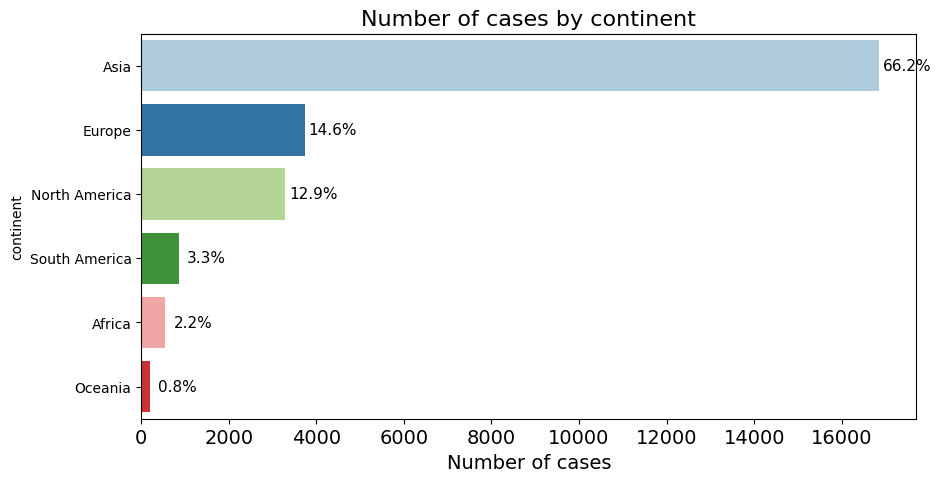

In [19]:
labeled_barplot(data=df, feature='continent', orient='v', perc=True, title='Number of cases by continent');

`education_of_employee`

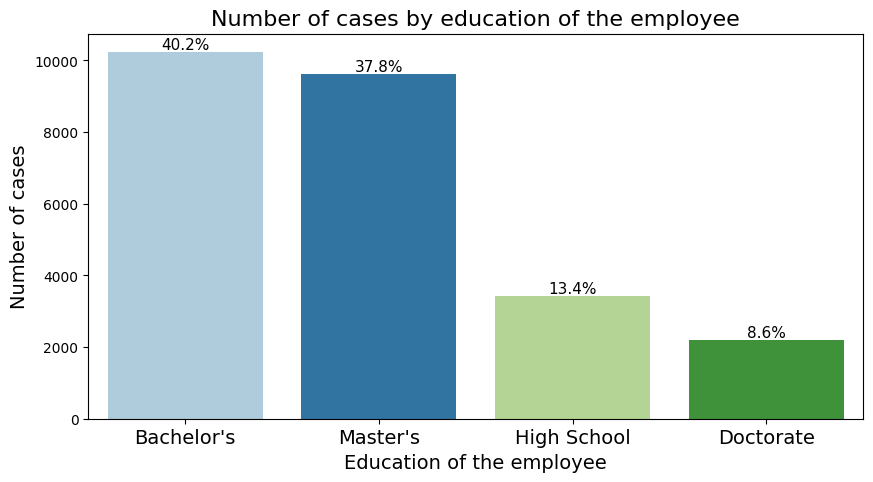

In [20]:
labeled_barplot(data=df, feature='education_of_employee', perc=True, 
                title='Number of cases by education of the employee', 
                xlabel='Education of the employee');

`has_job_experience`

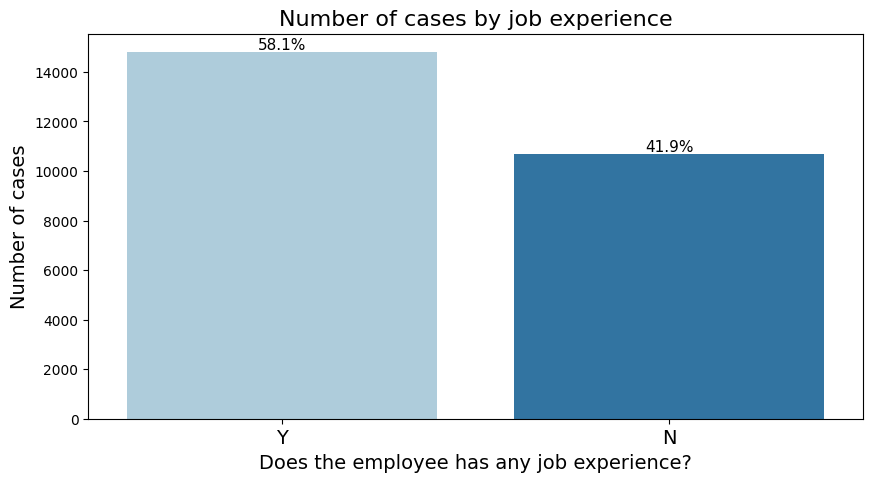

In [21]:
labeled_barplot(data=df, feature='has_job_experience', orient='h', perc=True, 
                title='Number of cases by job experience', 
                xlabel='Does the employee has any job experience?');

`requires_job_training`

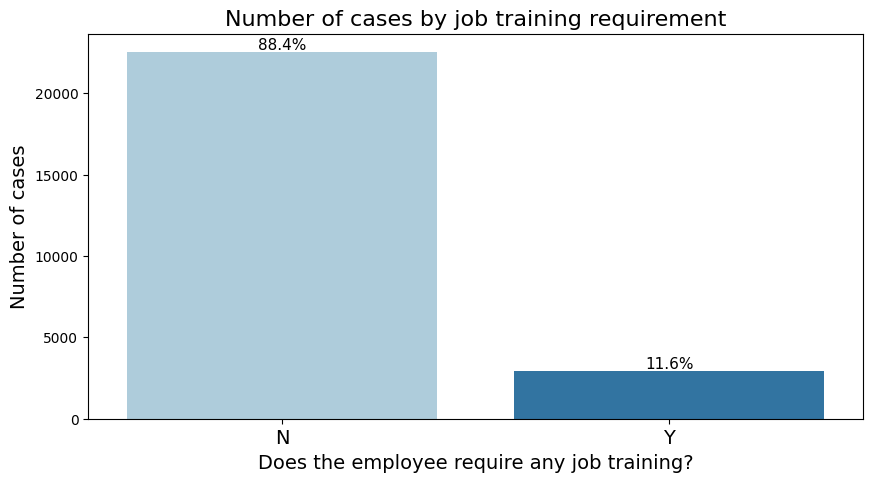

In [22]:
labeled_barplot(data=df, feature='requires_job_training', orient='h', perc=True, 
                title='Number of cases by job training requirement', 
                xlabel='Does the employee require any job training?');

`no_of_employees`

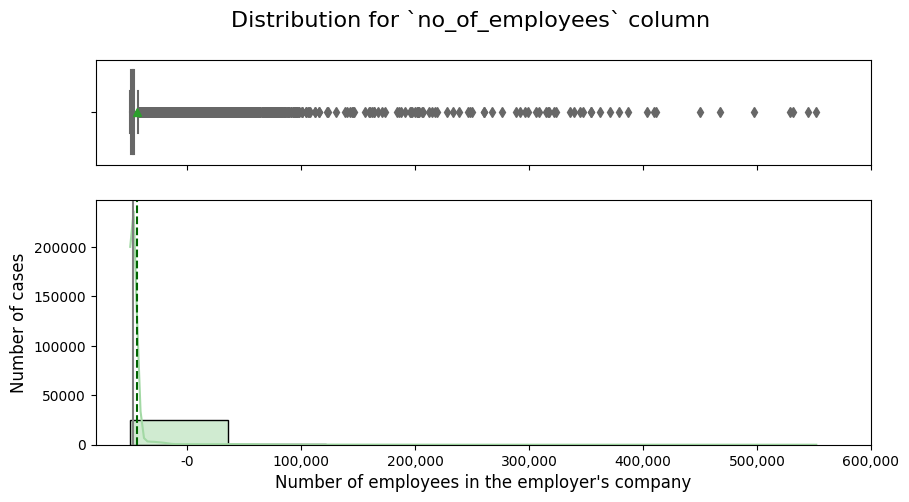

In [23]:
histogram_boxplot(df, 'no_of_employees', xlabel="Number of employees in the employer's company", step=100000, fmt='{:,.0f}');

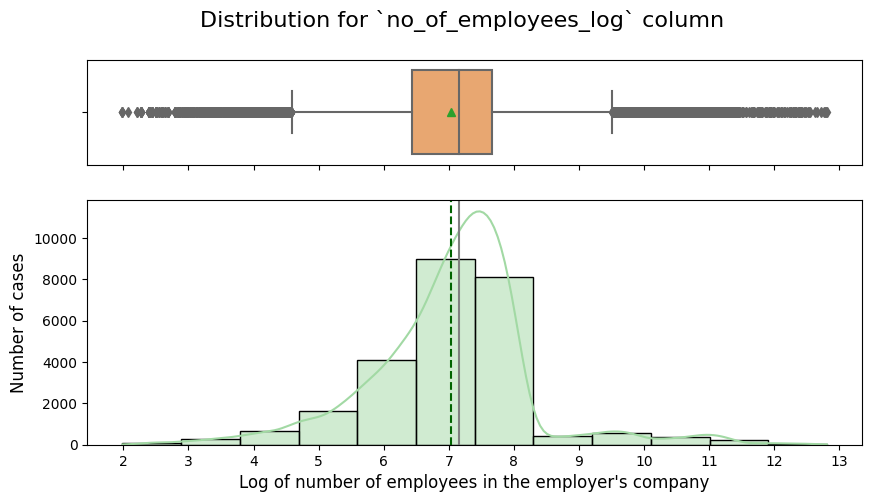

In [24]:
# it seems that log-transformation may improve visualization of the `no_of_employees` variable
df1 = df.copy()
df1['no_of_employees_log'] = np.log(df['no_of_employees'])
histogram_boxplot(df1, 'no_of_employees_log', xlabel="Log of number of employees in the employer's company", step=1, fmt='{:,.0f}');

`yr_of_estab`

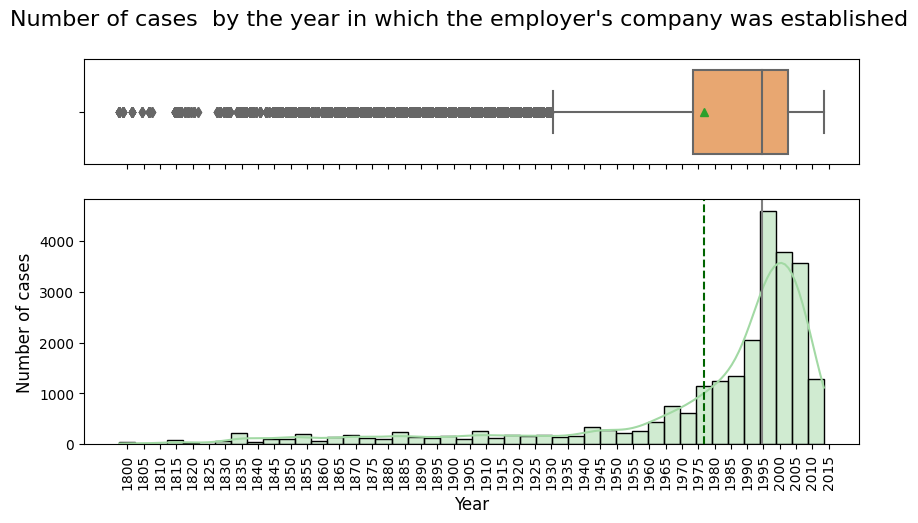

In [25]:
histogram_boxplot(df, 'yr_of_estab', 
                  title="Number of cases  by the year in which the employer's company was established", 
                  xlabel='Year', step=5, fmt='{:.0f}', rotation=90);

`region_of_employment`

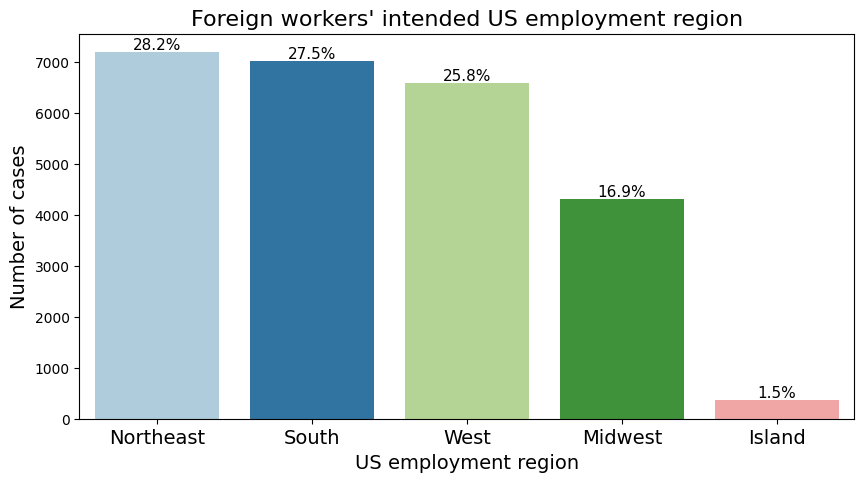

In [26]:
labeled_barplot(data=df, feature='region_of_employment', orient='h', perc=True, 
                title="Foreign workers' intended US employment region", xlabel='US employment region');

`prevailing_wage`

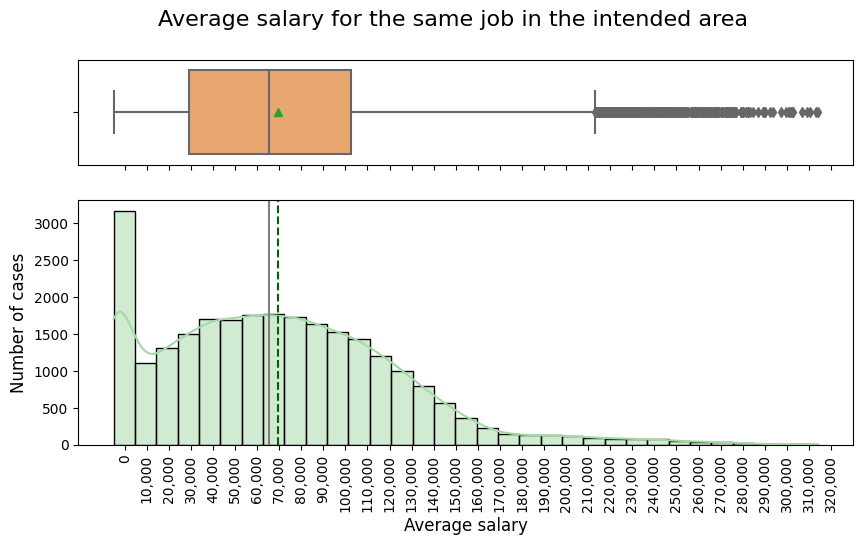

In [27]:
histogram_boxplot(df, 'prevailing_wage', title='Average salary for the same job in the intended area', 
                  xlabel='Average salary', step=10000, fmt='{:,.0f}', rotation=90);

* **Note**: *Please refer to the chart of `prevailing_wage` by `unit_of_wage` below. It is possible that some wages below $10,000 may be due to measurement issues.*

`unit_of_wage`

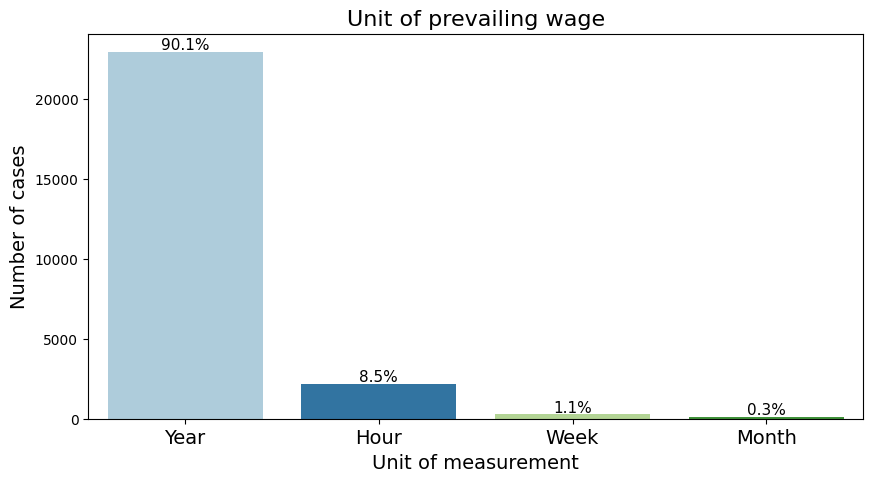

In [28]:
labeled_barplot(data=df, feature='unit_of_wage', orient='h', perc=True, title="Unit of prevailing wage", 
                xlabel='Unit of measurement');

`full_time_position`

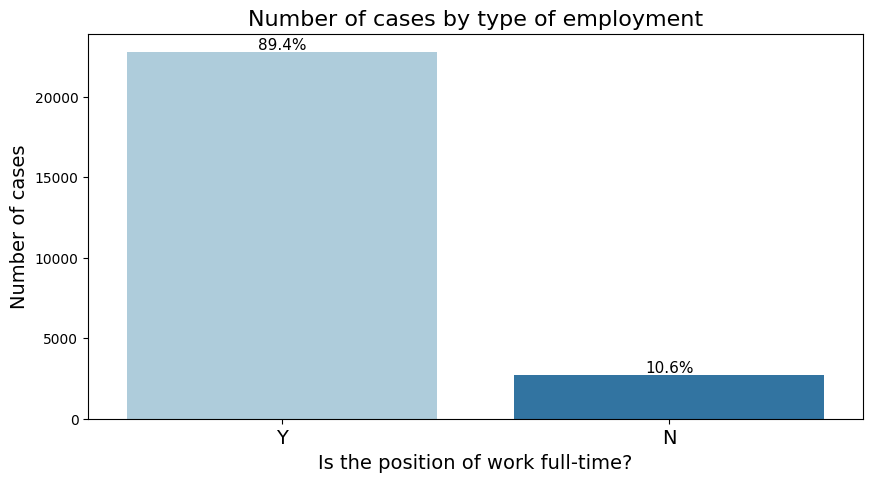

In [29]:
labeled_barplot(data=df, feature='full_time_position', orient='h', perc=True, 
                title='Number of cases by type of employment', 
                xlabel='Is the position of work full-time?');

`case_status`

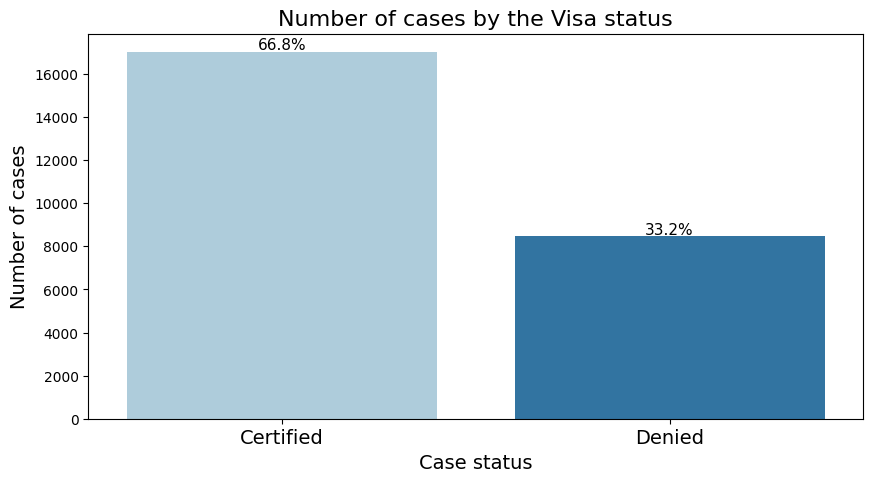

In [30]:
labeled_barplot(data=df, feature='case_status', orient='h', perc=True, 
                title='Number of cases by the Visa status', xlabel='Case status');

**Observations**:
* More than 66% of cases involve employees from Asia
* Out of the companies in the dataset, 75% of them have a workforce of 3504 employees or fewer, while the largest company in the dataset employs 602,069 people.
* Although there are many cases with a prevailing wage close to 0, the mean and median prevailing wage is around 70,000.
* The most prevalent education level among employees in the dataset is a Bachelor's degree(40.2%), followed closely by a Master's degree (37.8%).
* About 58% of cases in the dataset are from employees with prior job experience.
* About 88% of cases in the dataset are from employees who do not require any job training.
* About 89% of cases in the dataset are from employees who are seeking full-time job.
* The distribution of cases is generally similar across most regions, except for the `Island` region which has significantly fewer cases than the others. The `Midwest` region also has a slightly lower number of cases than the `Northeast`, `South`, and `West` regions.
* The 'Year' value is the most common in the 'unit_of_wage' column for most rows in the dataset.
* About two-thirds (67%) of the cases in the dataset were certified.

### Bivariate Analysis

**Pairplot of continuous numerical variables**

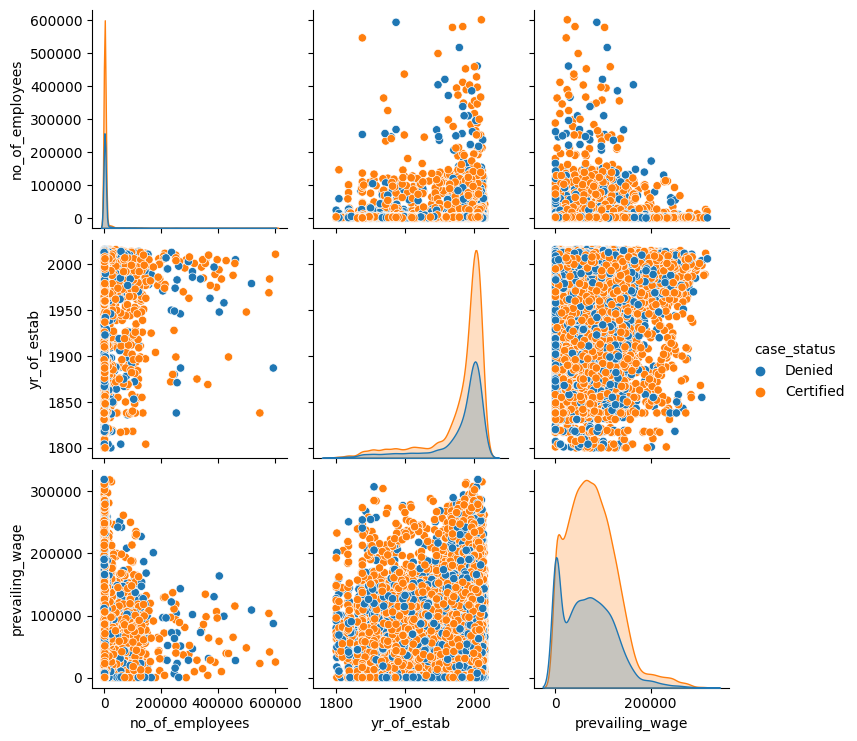

In [31]:
sns.pairplot(df, hue='case_status');

**Correlation heatmap**

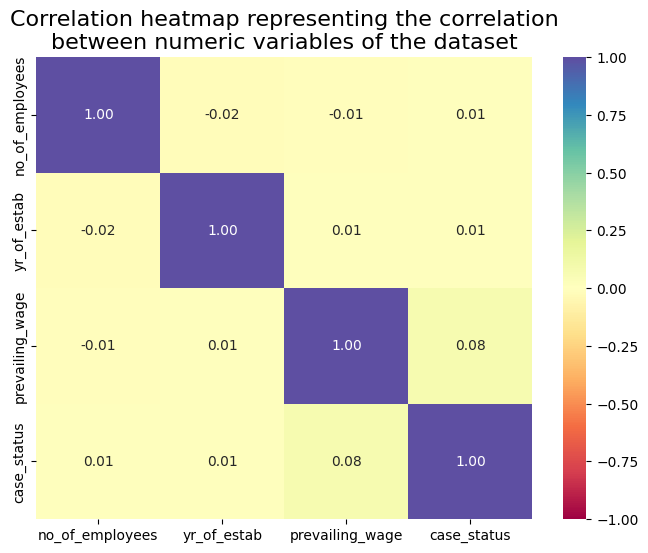

In [32]:
plt.figure(figsize=(8, 6))
sns.heatmap(pd.concat([df, pd.Series((df['case_status'] == 'Certified').astype(int))], axis=1).corr(),
            annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral")
plt.xlabel('')
plt.ylabel('')
plt.title('Correlation heatmap representing the correlation\nbetween numeric variables of the dataset',
          fontsize=16)
plt.show();

**Note**: *We observe little to no correlation among independent variables, as well as between independent variables and the dependent variable.*

**Leading Questions**:

**Q1.** Those with higher education may want to travel abroad for a well-paid job. Does education play a role in Visa certification? 

case_status            Certified  Denied    All
education_of_employee                          
All                        17018    8462  25480
Bachelor's                  6367    3867  10234
High School                 1164    2256   3420
Master's                    7575    2059   9634
Doctorate                   1912     280   2192
------------------------------------------------------------------------------------------------------------------------


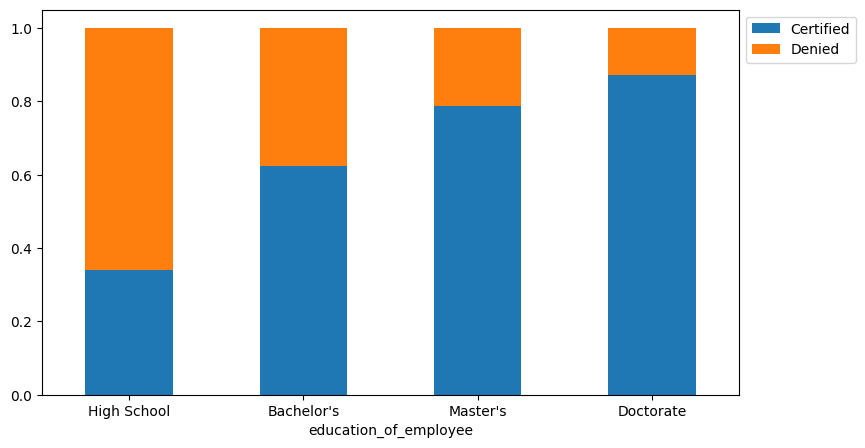

In [33]:
stacked_barplot(data, "education_of_employee", "case_status")

**A1:** Level of education appears to be a significant factor in Visa certification, with higher levels of education associated with a greater likelihood of Visa certification

**Q2.** How does the visa status vary across different continents? 

case_status    Certified  Denied    All
continent                              
All                17018    8462  25480
Asia               11012    5849  16861
North America       2037    1255   3292
Europe              2957     775   3732
South America        493     359    852
Africa               397     154    551
Oceania              122      70    192
------------------------------------------------------------------------------------------------------------------------


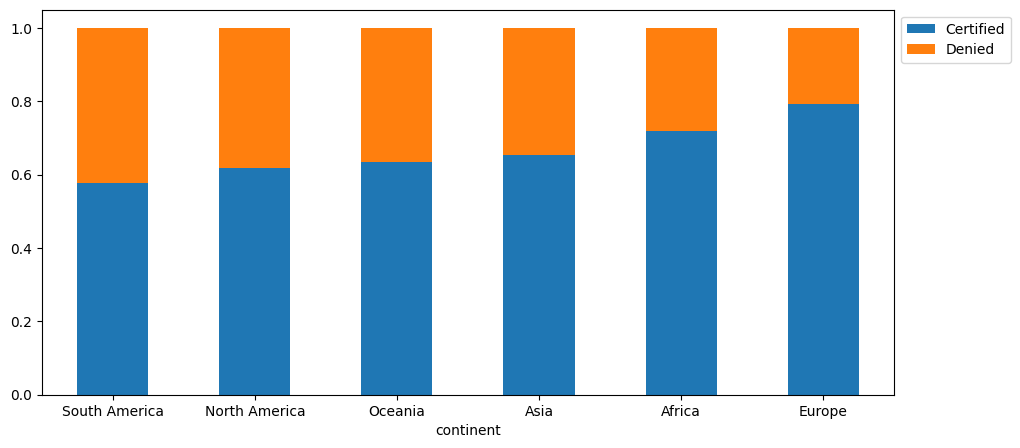

In [34]:
stacked_barplot(data, "continent", "case_status");

**A2.** Europe, Africa, and Asia have the highest rates of visa certification, in that order, with Oceania, North America, and South America following closely behind with a slight decrease in certification rates for each successive region.

**Q3.** Experienced professionals might look abroad for opportunities to improve their lifestyles and career development. Does work experience influence visa status?

case_status         Certified  Denied    All
has_job_experience                          
All                     17018    8462  25480
N                        5994    4684  10678
Y                       11024    3778  14802
------------------------------------------------------------------------------------------------------------------------


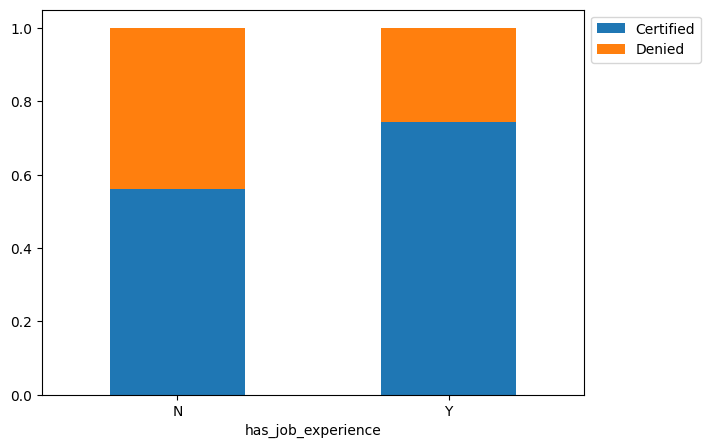

In [35]:
stacked_barplot(data, "has_job_experience", "case_status");

**A3.** From the data, it is evident that those who have work experience are certified at a higher rate.

**Q4.** In the United States, employees are paid at different intervals. Which pay unit is most likely to be certified for a visa?

case_status   Certified  Denied    All
unit_of_wage                          
All               17018    8462  25480
Year              16047    6915  22962
Hour                747    1410   2157
Week                169     103    272
Month                55      34     89
------------------------------------------------------------------------------------------------------------------------


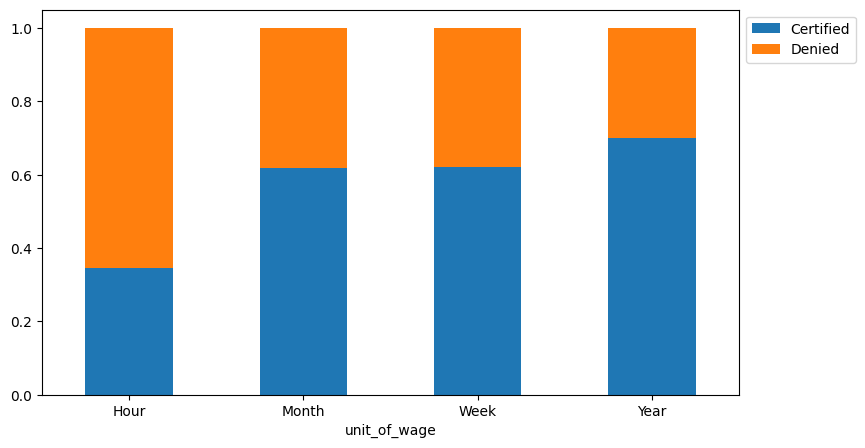

In [36]:
stacked_barplot(data, "unit_of_wage", "case_status");

**A4.** It appears that employees who are paid on a yearly-unit basis have a greater chance of being certified for a Visa, while those who are paid hourly-unit are more likely to be denied.

**Q5.** The US government has established a prevailing wage to protect local talent and foreign workers. How does the visa status change with the prevailing wage?

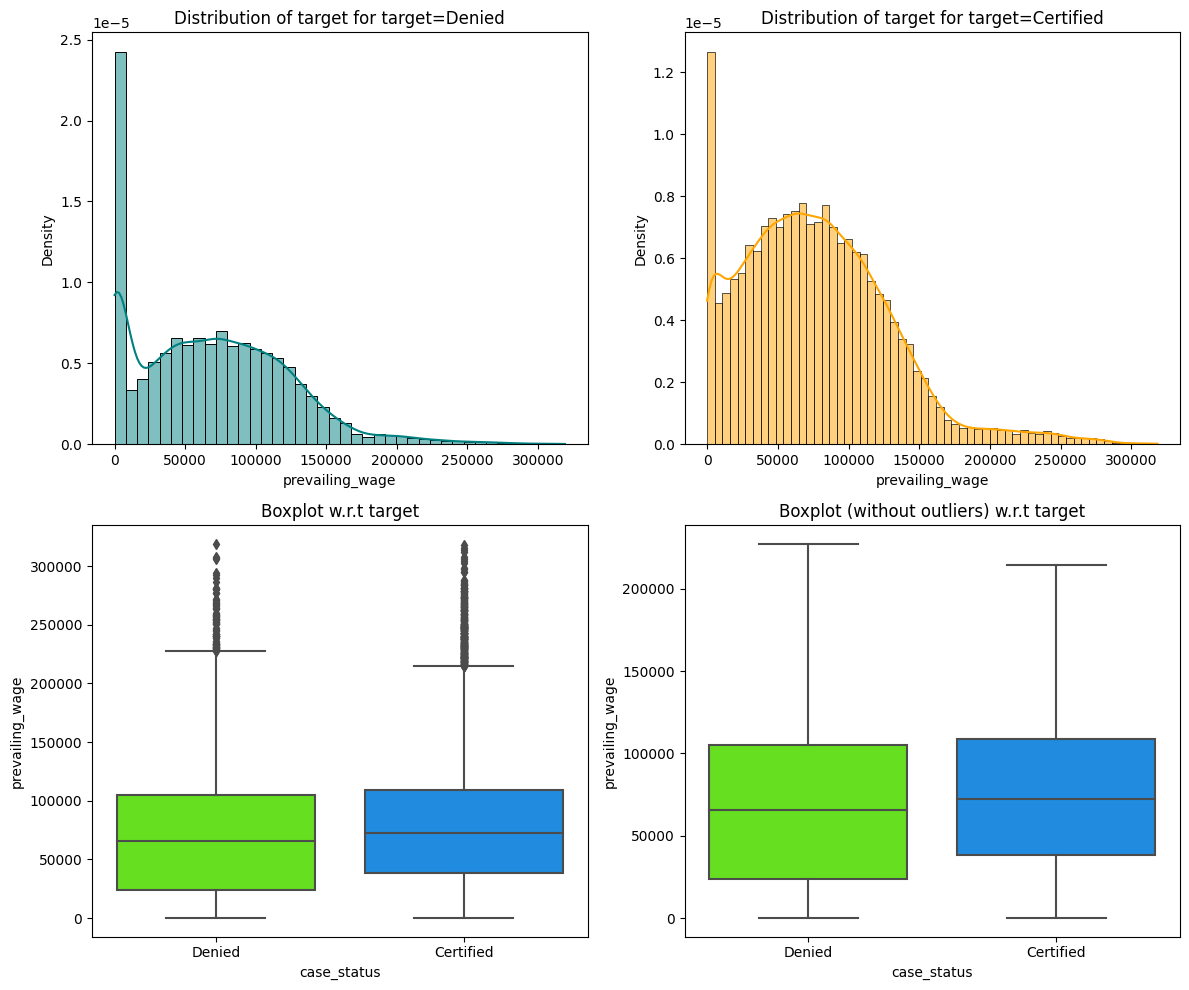

In [37]:
distribution_plot_wrt_target(data, 'prevailing_wage', 'case_status') 

In [38]:
data.groupby('case_status')['prevailing_wage'].describe()

count          mean           std     min        25%       50%  \
case_status                                                                     
Certified    17018.0  77293.619243  52042.715576  2.1367  38375.330  72486.27   
Denied        8462.0  68748.681580  53890.166031  2.9561  23497.295  65431.46   

                     75%        max  
case_status                          
Certified    108879.1075  318446.05  
Denied       105097.6400  319210.27

**A5.** The prevailing wage distribution is comparable between both groups, with some minor differences:
* The upper whisker (Q3+1.5IQR or the highest value that is not considered an outlier on the plot) is similar in both groups.
* There is a slightly higher prevailing wage range for those who were denied compared to those who were certified.
* The median prevailing wage is slightly higher for those who were certified compared to those who were denied.

## Data Preprocessing

- Missing value treatment (if needed)
- Feature engineering 
- Outlier detection and treatment (if needed)
- Preparing data for modeling 
- Any other preprocessing steps (if needed)

### Missing value treatment (if needed)

In [39]:
print(f'Total number of missing values is {df.isnull().sum().sum()}')

Total number of missing values is 0


* There is no missing values (NaN, None, etc.) in the dataset
* Statistical summary of the dataset shows that there is no unexpected zeroes in the dataset as well

### Feature engineering

#### Wrong data
* *Wrong data refers to data that is incorrect, inaccurate, or does not reflect reality.*
* *Such data may have been inputted incorrectly, or there may have been errors in processing or recording the data. Wrong data can lead to incorrect analysis and decision-making.*
* *Therefore, it is important to carefully check the data to ensure that it is accurate before using it for any decision-making purposes.*

In [40]:
#Fixing the negative values in number of employees columns
df = df[df['no_of_employees']>0]

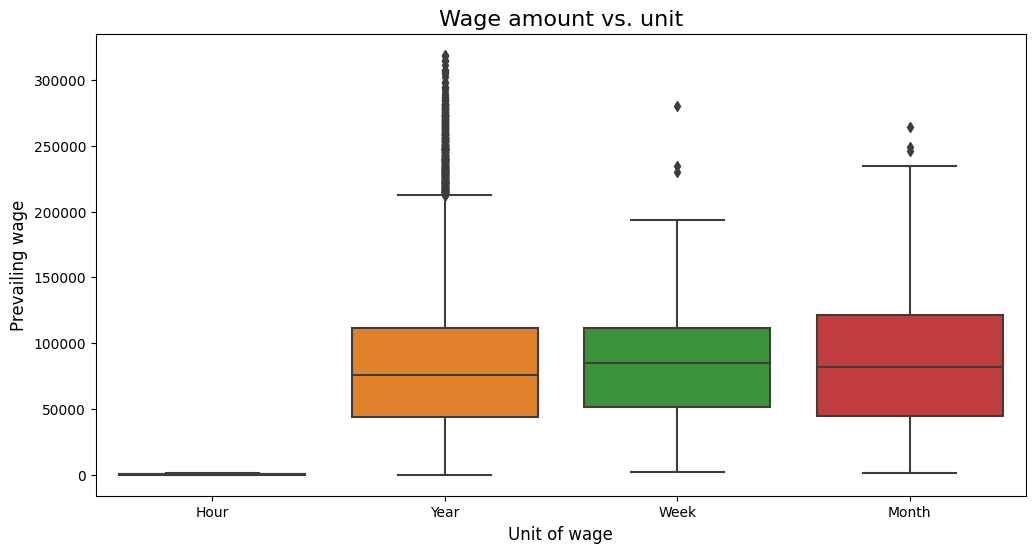

In [41]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.boxplot(data=df, x='unit_of_wage', y='prevailing_wage', ax=ax)
plt.xlabel('Unit of wage', fontsize=12)
plt.ylabel('Prevailing wage', fontsize=12)
plt.title('Wage amount vs. unit', fontsize=16)
plt.show();

* It appears that the weekly, monthly, and yearly wages in the dataset were converted to annual equivalents, while the hourly wages were left as is. 
* We have decided not to change hourly to annual equivalent, as unit of measurement `unit_of_wage` maintains consistency these data in the dataset.
* While it may make some comparisons between hourly and salaried employees less straightforward, this conversion method provides a useful way to compare wages across different payment frequencies.

#### Fixing the data types

In [42]:
for i in cols_cat.columns:
  df[i] = df[i].astype('category')

#### Dropping column which is not adding any information

In [43]:
#Dropping the `case_id` colum with all unique values
df.drop(['case_id'], axis=1, inplace=True)

#### Converting the categorical target variable into a numerical binary variable

In [44]:
df['case_status'] = df['case_status'].apply(lambda x : 1 if x=='Certified' else 0)

### Outlier detection and treatment (if needed)

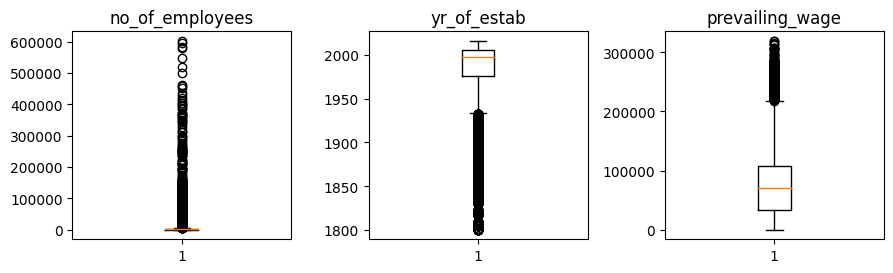

In [45]:
# outlier detection using boxplot
numeric_columns = df.select_dtypes(include=[int, float]).columns.tolist()

plt.figure(figsize=(12, 10))

for i, variable in enumerate(numeric_columns):
    plt.subplot(4, 4, i + 1)
    plt.boxplot(df[variable], whis=1.5)
    plt.tight_layout()
    plt.title(variable)

plt.show();

**Observations**

* There are quite a few outliers in the data
* They are proper values

### Preparing data for modeling

In [46]:
X = df.drop(['case_status'], axis=1)
X = pd.get_dummies(X, drop_first=True)
y = df['case_status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

In [47]:
print("Shape of Training set : ", X_train.shape)
print("Shape of Testing set : ", X_test.shape)
print("Percentage of classes in training set:")
print(y_train.value_counts(normalize=True))
print("Percentage of classes in test set:")
print(y_test.value_counts(normalize=True))

Shape of Training set :  (17812, 21)
Shape of Testing set :  (7635, 21)
Percentage of classes in training set:
1    0.668089
0    0.331911
Name: case_status, dtype: float64
Percentage of classes in test set:
1    0.668107
0    0.331893
Name: case_status, dtype: float64


### Any other preprocessing steps (if needed)

* No any other preprocessing steps are needed

## EDA

- It is a good idea to explore the data once again after manipulating it.

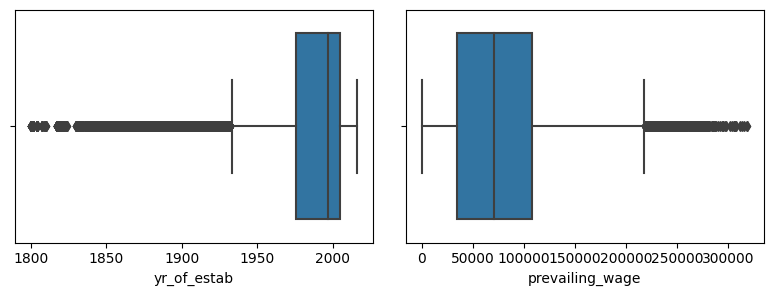

In [48]:
# Numerical variables
cols = X.select_dtypes(include=[int, float]).columns.tolist()[1:]
plt.figure(figsize=(12, 12))

for i, var in enumerate(cols):
  plt.subplot(4, 3, i + 1)
  sns.boxplot(data=X, x=var)
  plt.tight_layout(pad=2)

plt.tight_layout(pad=2);
plt.show();

**Bivariate analysis**

**Correlation heatmap**

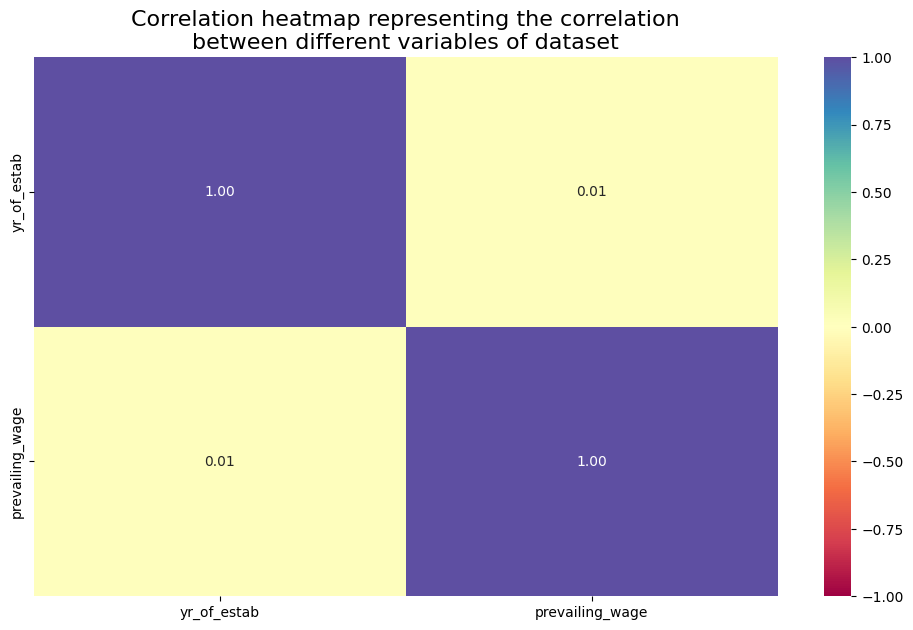

In [49]:
numeric = list(X.select_dtypes(include=[int, float]).columns[1:])

plt.figure(figsize=(12, 7))
sns.heatmap(pd.concat([X[numeric], y], axis=1).corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral")
plt.xlabel('')
plt.ylabel('')
plt.title('Correlation heatmap representing the correlation\nbetween different variables of dataset', fontsize=16)
plt.show();

**Pairplot**

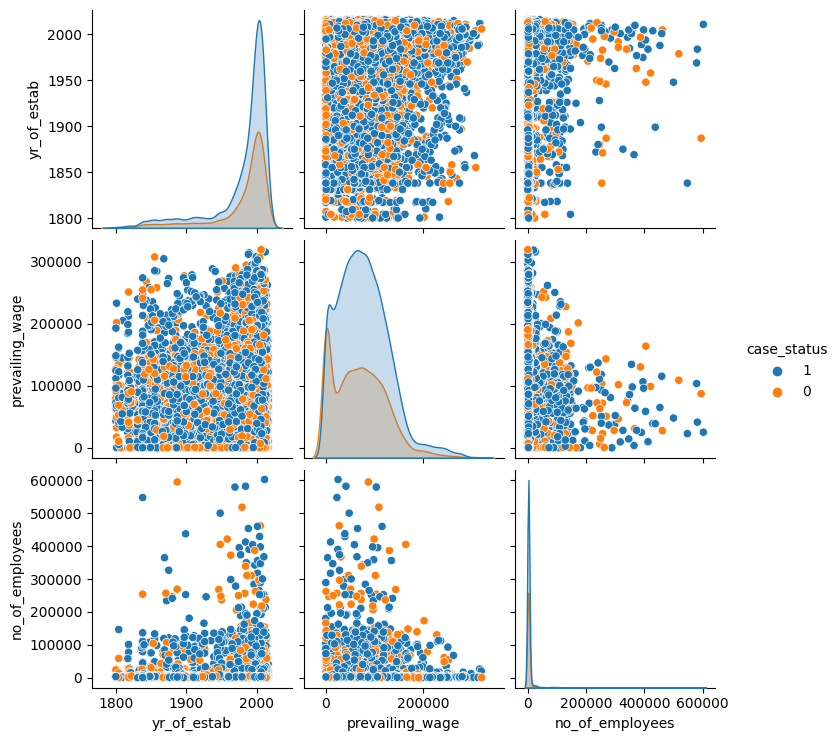

In [50]:
sns.pairplot(pd.concat([X[['yr_of_estab', 'prevailing_wage', 'no_of_employees']], y], axis=1), hue='case_status');

* **After manipulating, the data look consistent**

## Building bagging and boosting models

## **Bagging models**

### Model evaluation criterion

### The model evaluation criterion will be based on the following potential incorrect predictions:

False positive - predicting a case will be certified when it is actually denied.
False negative - predicting a case will be denied when it is actually certified.

We will use these criteria to evaluate the performance of the model.

### Which case is more important? 
* **[FP]** If a visa is mistakenly certified, it could result in an unqualified individual being hired for a position that should have been filled by a qualified US citizen. This could lead to US citizens missing out on job opportunities that they are qualified for.

* **[FN]** If a visa is mistakenly denied, a qualified candidate may be lost to the US economy, which could result in the loss of valuable skills, knowledge, and experience that could have contributed to economic growth and development.

### How to reduce this loss i.e need to reduce False Negatives?
* We aim to create a recommendation system for determining whether visa applicants should be certified or denied based on factors that significantly impact case status. To achieve this, it is essential to consider both precision and recall in the evaluation process.
* We will use the F1 Score as our evaluation metric since it takes into account both precision and recall. A higher F1 Score indicates a lower likelihood of encountering False Negatives and False Positives, leading to a more accurate model.
* Given that the target has imbalanced classes, with roughly one-third of cases being denied and two-thirds being certified, we recommend using balanced class weights to address this imbalance. This approach helps to prevent the model from favoring the majority class and enhances its performance on the minority class. By employing balanced class weights, the model can assign equal importance to both classes during training, which may result in better overall accuracy.

###Decision Tree Model

* We will build our model using the DecisionTreeClassifier function. Using default 'gini' criteria to split. 
* If the frequency of class A is 33% and the frequency of class B is 67%, then class B will become the dominant class and the decision tree will become biased toward the dominant classes.
* In this case, we can pass a dictionary {0: 0.67, 1: 0.33} to the model to specify the weight of each class and the decision tree will give more weightage to class 0.
* class_weight is a hyperparameter for the decision tree classifier.

In [51]:
classes = pd.Series(y_train).unique()
class_weight = {}
class_weight_list = compute_class_weight(class_weight = 'balanced', classes = classes, y = y_train)

for i, v in enumerate(class_weight_list):
  class_weight[classes[i]] = round(v / class_weight_list.sum(), 2)

print(class_weight)

{1: 0.33, 0: 0.67}


In [52]:
dtree = DecisionTreeClassifier(criterion='gini', class_weight=class_weight, random_state=42)
dtree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight={0: 0.67, 1: 0.33}, random_state=42)

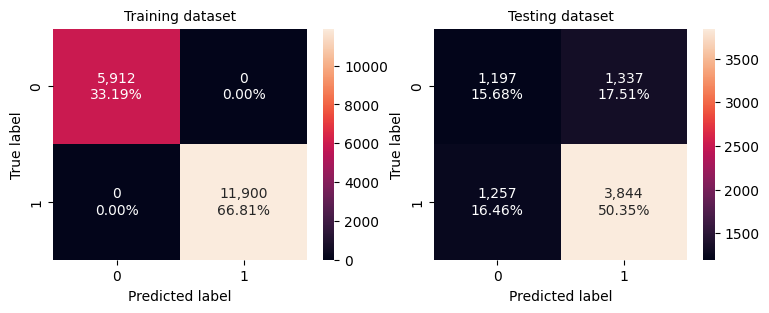

In [53]:
dtree_perf = model_performance(dtree, X_train, y_train, X_test, y_test, verbose=True)

**Confusion Matrix:**

* A **True Positive** occurs when a certified visa case (observed=1) is correctly predicted as certified (predicted=1) by the model.

* A **False Positive** occurs when the model incorrectly predicts a visa case as certified (predicted=1) when it is actually denied (observed=0).

* A **True Negative** occurs when the model correctly predicts a visa case as denied (predicted=0) when it is actually denied (observed=0).

* A **False Negative** occurs when the model incorrectly predicts a visa case as denied (predicted=0) when it is actually certified (observed=1).

* **Decision tree** is working well on the training data but is not able to generalize well on the test data concerning the F1 score.

### Bagging Classifier

In [54]:
bagging = BaggingClassifier(random_state=42)
bagging.fit(X_train, y_train)

BaggingClassifier(random_state=42)

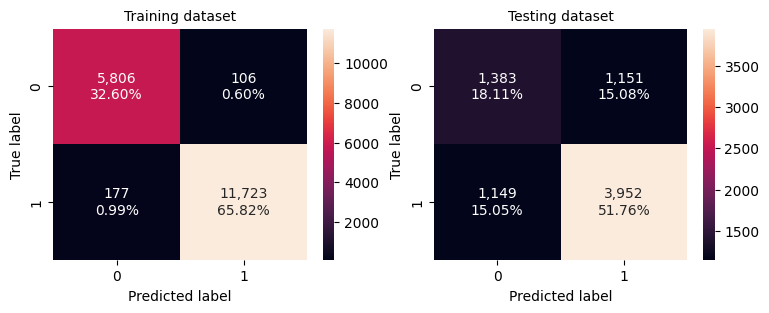

In [55]:
bagging_perf = model_performance(bagging, X_train, y_train, X_test, y_test, verbose=True)

* A **Bagging Classifier** is overfitting on the training set when it achieves high performance on the training data but performs poorly on the test data. This indicates that the model has learned the training data too well, capturing noise and peculiarities that do not generalize to unseen data. 
* Although the Bagging Classifier outperforms the Decision Tree, its subpar performance on the test set in terms of F1 score suggests that it may not be the best model for the task..

### Bagging Classifier with weighted decision tree

In [56]:
bagging_wt = BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=class_weight,
                                                                     random_state=42),
                               random_state=42)
bagging_wt.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight={0: 0.67,
                                                                      1: 0.33},
                                                        random_state=42),
                  random_state=42)

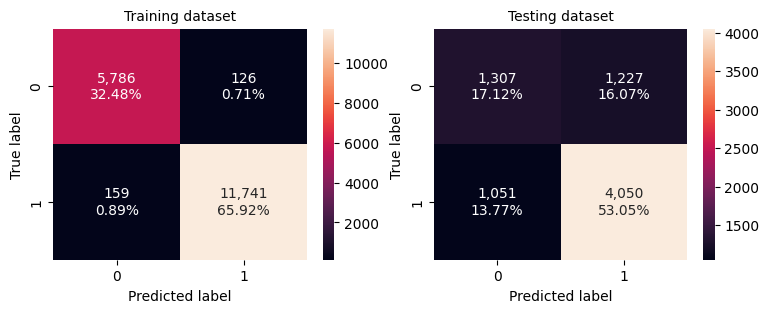

In [57]:
bagging_wt_perf = model_performance(bagging_wt, X_train, y_train, X_test, y_test, verbose=True)

* A **Bagging classifier with a weighted decision tree** is achieving high accuracy and prediction performance. However, it struggles to generalize well on the test data in terms of F1 score.
* Despite this issue, the model's recall, precision, and F1 scores on the test data are better than those of the Boosting model without a weighted decision tree.

### Random Forest

In [58]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

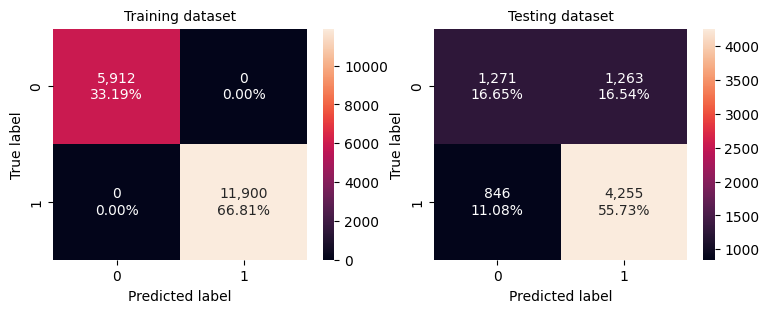

In [59]:
rf_perf = model_performance(rf, X_train, y_train, X_test, y_test, verbose=True)

* **Random Forest** has performed well in terms of accuracy, precision, recall and F1 score, but it is not able to generalize well on the test data in terms of F1 score.

### Random forest with class weights

In [60]:
rf_wt = RandomForestClassifier(class_weight=class_weight,
                               random_state=42)
rf_wt.fit(X_train, y_train)

RandomForestClassifier(class_weight={0: 0.67, 1: 0.33}, random_state=42)

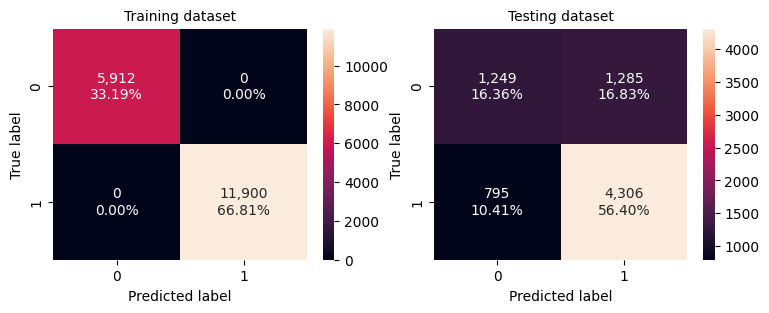

In [61]:
rf_wt_perf = model_performance(rf_wt, X_train, y_train, X_test, y_test, verbose=True)

* There is not much improvement in metrics of **Weighted Random Forest** as compared to the unweighted random forest.

## **Boosting models**

### AdaBoost Classifier

In [62]:
abc = AdaBoostClassifier(random_state=42)
abc.fit(X_train, y_train)

AdaBoostClassifier(random_state=42)

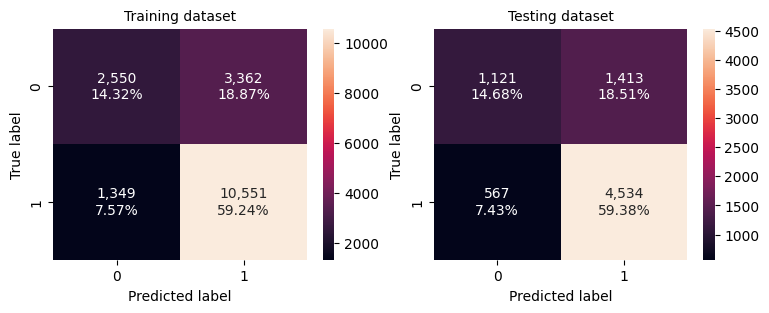

In [63]:
abc_perf = model_performance(abc, X_train, y_train, X_test, y_test, verbose=True)

* **AdaBoostClassifier** is generalizing well but and giving good performance, in terms of F1 score as well as Precision and Recall, as compared to the Decision tree, Bagging, and Random forest models.  

### Gradient Boosting Classifier

In [64]:
gbc = GradientBoostingClassifier(random_state=42)
gbc.fit(X_train, y_train)

GradientBoostingClassifier(random_state=42)

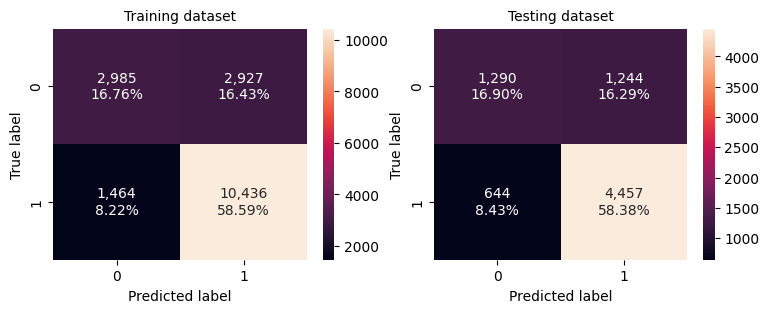

In [65]:
gbc_perf = model_performance(gbc, X_train, y_train, X_test, y_test, verbose=True)

* **GradientBoostingClassifier** is generalizing well and giving decent results but not as good as AdaBoostClassifier.

### XGBoost Classifier

In [66]:
xgb = XGBClassifier(random_state=42)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

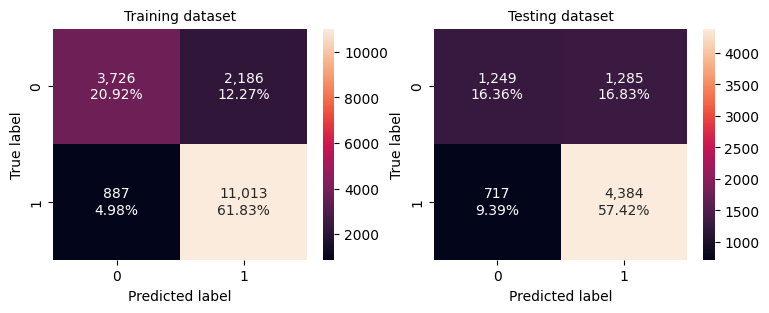

In [67]:
xgb_perf = model_performance(xgb, X_train, y_train, X_test, y_test, verbose=True)

* **XGBoost Classifier** with default parameters is giving almost as good results as the GBM and AdaBoost models.

##  Will tuning the hyperparameters improve the model performance?

## Optimizing **Bagging Models** through Hyperparameter Tuning

###Hyperparameter Tuning - Decision Tree

In [68]:
# Choose the type of classifier.
dtree_tuned = DecisionTreeClassifier(class_weight=class_weight, random_state=42)

# Grid of parameters to choose from
parameters = {
    'max_depth': [None] + list(np.arange(9, 20, 9)), 
    'min_samples_split': [3, 5, 7],
    'min_samples_leaf': [2, 3, 4],
    'max_features': [None, 'sqrt', 'log2'],
    'max_leaf_nodes': [None] + list(np.arange(7, 50, 14))
    }

# Run the grid search
grid_obj = GridSearchCV(dtree_tuned, parameters, cv=5, scoring='f1', n_jobs=-1) 

grid_obj = grid_obj.fit(X_train, y_train) 

# Set the clf to the best combination of parameters
dtree_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data.
dtree_tuned.fit(X_train, y_train)

DecisionTreeClassifier(class_weight={0: 0.67, 1: 0.33}, max_leaf_nodes=21,
                       min_samples_leaf=2, min_samples_split=3,
                       random_state=42)

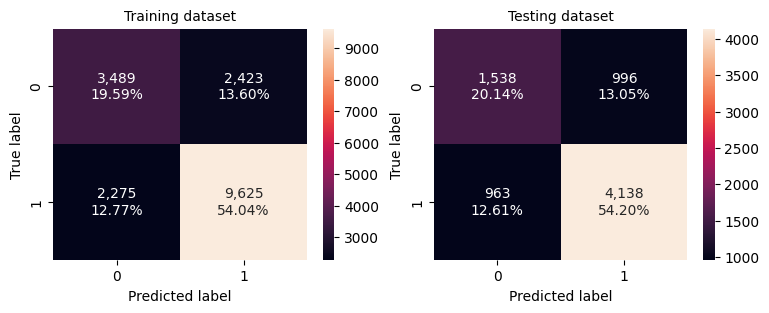

In [69]:
dtree_tuned_perf = model_performance(dtree_tuned, X_train, y_train, X_test, y_test, verbose=True)

* **A Tuned Decision Tree** yields a slightly lower F1 score compared to a Gradient Boosting Machine (GBM); however, it exhibits higher precision.

### Hyperparameter Tuning - Bagging Classifier

In [70]:
# Choose the type of classifier.
bagging_tuned = BaggingClassifier(random_state=42)

# Grid of parameters to choose from
parameters = {
    'base_estimator': [DecisionTreeClassifier(max_depth=1, random_state=42),
                       DecisionTreeClassifier(max_depth=2, random_state=42),
                       DecisionTreeClassifier(max_depth=3, random_state=42)],
              'n_estimators': [50, 100, 200],
              }

# Run the grid search
grid_obj = GridSearchCV(bagging_tuned, parameters, cv=5, scoring='f1', n_jobs=-1) 

grid_obj = grid_obj.fit(X_train, y_train) 

# Set the clf to the best combination of parameters
bagging_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data.
bagging_tuned.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=3,
                                                        random_state=42),
                  n_estimators=200, random_state=42)

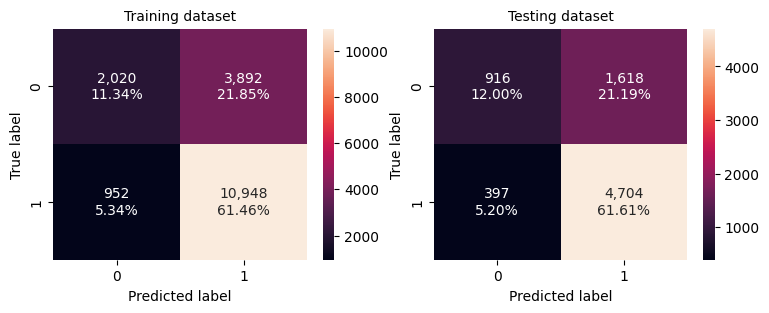

In [71]:
bagging_tuned_perf = model_performance(bagging_tuned, X_train, y_train, X_test, y_test, verbose=True)

* **A Tuned Bagging Classifier**  achieves an F1 score similar to that of a Gradient Boosting Machine (GBM); however, it demonstrates the **highest NPV** (Negative Predictive Value).

### Hyperparameter Tuning - Bagging Classifier with weighted decision tree

In [72]:
# Choose the type of classifier.
bagging_wt_tuned = BaggingClassifier(random_state=42)

# Grid of parameters to choose from
parameters = {
    'base_estimator': [DecisionTreeClassifier(max_depth=1, class_weight=class_weight, random_state=42)],
    'n_estimators': [50, 100, 200],
    }

# Run the grid search
grid_obj = GridSearchCV(bagging_wt_tuned, parameters, cv=5, scoring='f1', n_jobs=-1) 

grid_obj = grid_obj.fit(X_train, y_train) 

# Set the clf to the best combination of parameters
bagging_wt_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data.
bagging_wt_tuned.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight={0: 0.67,
                                                                      1: 0.33},
                                                        max_depth=1,
                                                        random_state=42),
                  n_estimators=50, random_state=42)

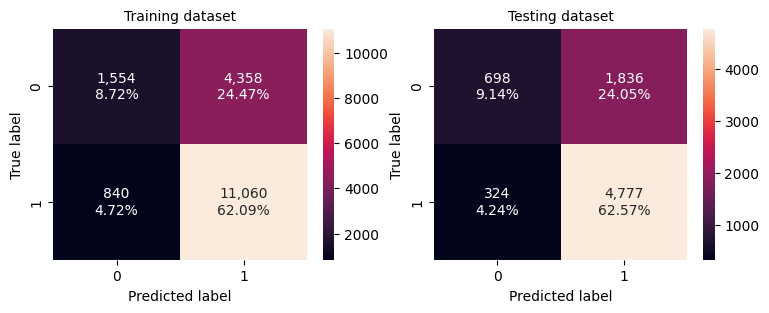

In [73]:
bagging_wt_tuned_perf = model_performance(bagging_wt_tuned, X_train, y_train, X_test, y_test, verbose=True)

* **A Tuned Weighted Bagging Classifier** achieves a slightly lower F1 score compared to the Tuned Unweighted Bagging Classifier; however, it exhibits the **highest Recall**.

### Hyperparameter Tuning - Random Forest

In [74]:
# Choose the type of classifier.
rf_tuned = RandomForestClassifier(random_state=42)

# Grid of parameters to choose from
parameters = {
    'max_depth': [None] + list(np.arange(6, 12, 3)),
    'min_samples_leaf': [5],
    'max_features': ['auto']
    }

# Run the grid search
grid_obj = GridSearchCV(rf_tuned, parameters, cv=5, scoring='f1', n_jobs=-1) 

grid_obj = grid_obj.fit(X_train, y_train) 

# Set the clf to the best combination of parameters
rf_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data.
rf_tuned.fit(X_train, y_train)

RandomForestClassifier(max_depth=9, max_features='auto', min_samples_leaf=5,
                       random_state=42)

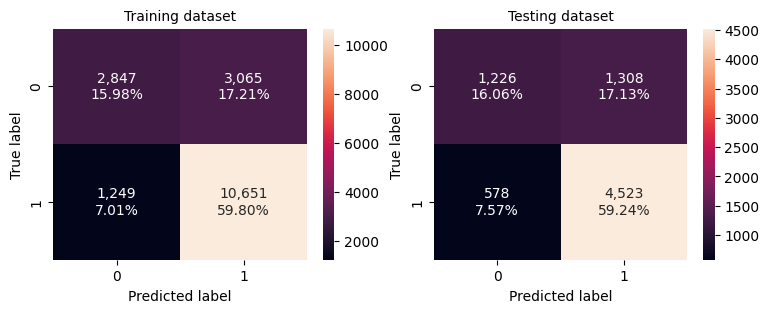

In [75]:
rf_tuned_perf = model_performance(rf_tuned, X_train, y_train, X_test, y_test, verbose=True)

* **A Tuned Random Forest** demonstrates the **highest F1 score** among the models compared.

### Hyperparameter Tuning - Random forest with class weights

In [76]:
# Choose the type of classifier.
rf_wt_tuned = RandomForestClassifier(random_state=42)

# Grid of parameters to choose from
parameters = {
    'n_estimators': [50, 100],
    'min_samples_split': [3, 5],
    'min_samples_leaf': [2, 3],
    }

# Run the grid search
grid_obj = GridSearchCV(rf_wt_tuned, parameters, cv=5, scoring='f1', n_jobs=-1) 

grid_obj = grid_obj.fit(X_train, y_train) 

# Set the clf to the best combination of parameters
rf_wt_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data.
rf_wt_tuned.fit(X_train, y_train)

RandomForestClassifier(min_samples_leaf=3, min_samples_split=3, random_state=42)

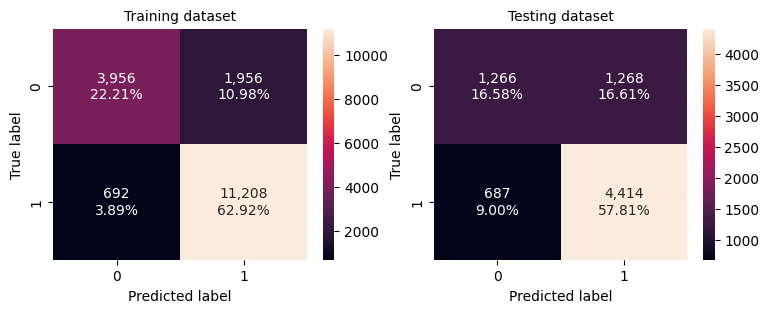

In [77]:
rf_wt_tuned_perf = model_performance(rf_wt_tuned, X_train, y_train, X_test, y_test, verbose=True)

* **A Tuned Weighted Random Forest** shows the lowest performance in all metrics among the tuned models being compared.

## Optimizing **Boosting models** through Hyperparameter Tuning

### Hyperparameter Tuning - AdaBoost Classifier

In [78]:
# Choose the type of classifier.
abc_tuned = AdaBoostClassifier(random_state=42)

# Grid of parameters to choose from
parameters = {
    'n_estimators': [100, 200],
    'learning_rate': [0.001, 0.01],
    'algorithm': ['SAMME', 'SAMME.R'],
    'base_estimator': [DecisionTreeClassifier(max_depth=d) for d in range(1, 5, 2)]
}

# Run the grid search
grid_obj = GridSearchCV(abc_tuned, parameters, cv=5, scoring='f1', n_jobs=-1) 

grid_obj = grid_obj.fit(X_train, y_train) 

# Set the clf to the best combination of parameters
abc_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data.
abc_tuned.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3),
                   learning_rate=0.01, n_estimators=200, random_state=42)

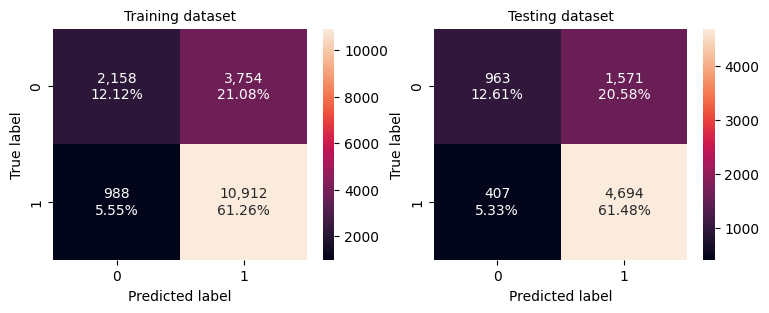

In [79]:
abc_tuned_perf = model_performance(abc_tuned, X_train, y_train, X_test, y_test, verbose=True)

* **A Tuned AdaBoost Classifier** demonstrates good average performance across all metrics when compared to other models, and it ranks fourth in our list of models.

### Hyperparameter Tuning - Gradient Boosting Classifier

In [80]:
# Choose the type of classifier.
gbc_tuned = GradientBoostingClassifier(random_state=42)

# Grid of parameters to choose from
parameters = {
    'n_estimators': [50, 75],
    'init': [None, AdaBoostClassifier(random_state=42)],
    'max_features': [None, 'auto'],
    }

# Run the grid search
grid_obj = GridSearchCV(gbc_tuned, parameters, cv=5, scoring='f1', n_jobs=-1) 

grid_obj = grid_obj.fit(X_train, y_train) 

# Set the clf to the best combination of parameters
gbc_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data.
gbc_tuned.fit(X_train, y_train)

GradientBoostingClassifier(n_estimators=50, random_state=42)

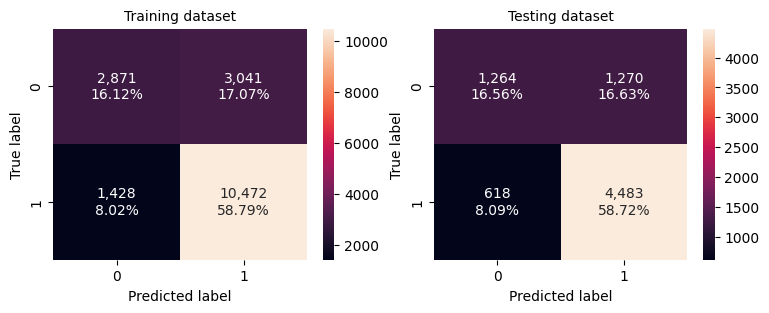

In [81]:
gbc_tuned_perf = model_performance(gbc_tuned, X_train, y_train, X_test, y_test, verbose=True)

* **A Tuned Gradient Boosting Classifier** ranks third in terms of F1 score performance among the compared models.

### Hyperparameter Tuning - XGBoost Classifier

In [82]:
# Choose the type of classifier.
xgb_tuned = XGBClassifier(eval_metric='logloss',
                          random_state=42)

# Grid of parameters to choose from
parameters = {
    'n_estimators': [50, 100],
    'learning_rate': [0.01, 0.001],
    'gamma': [5, 6],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 0.7],
    'colsample_bylevel': [1.0]
    }

# Run the grid search
grid_obj = GridSearchCV(xgb_tuned, parameters, cv=5, scoring='f1', n_jobs=-1) 

grid_obj = grid_obj.fit(X_train, y_train) 

# Set the clf to the best combination of parameters
xgb_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data.
xgb_tuned.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=1.0, colsample_bynode=None,
              colsample_bytree=0.8, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=5, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.001, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=42, ...)

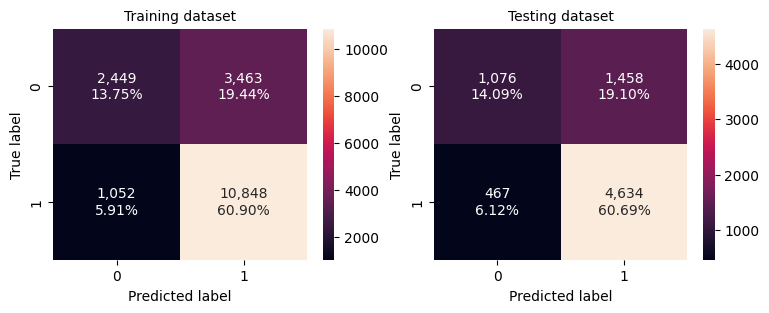

In [83]:
xgb_tuned_perf = model_performance(xgb_tuned, X_train, y_train, X_test, y_test, verbose=True)

* **A Tuned XGBoost Classifier** demonstrates fairly mediocre results. Perhaps a more precise tuning of the hyperparameters can improve the performance.

### Stacking

In [84]:
# Choose the type of classifier.
stacking = StackingClassifier(estimators = [('rf', RandomForestClassifier(random_state=42)),
                                            ('knn', AdaBoostClassifier(random_state=42)),
                                            ('dt', GradientBoostingClassifier(random_state=42))],
                              final_estimator = XGBClassifier(eval_metric='logloss', random_state=42))

stacking.fit(X_train, y_train) 

StackingClassifier(estimators=[('rf', RandomForestClassifier(random_state=42)),
                               ('knn', AdaBoostClassifier(random_state=42)),
                               ('dt',
                                GradientBoostingClassifier(random_state=42))],
                   final_estimator=XGBClassifier(base_score=None, booster=None,
                                                 callbacks=None,
                                                 colsample_bylevel=None,
                                                 colsample_bynode=None,
                                                 colsample_bytree=None,
                                                 early_stopping_rounds=None,
                                                 enable_c...
                                                 gpu_id=None, grow_policy=None,
                                                 importance_type=None,
                                                 interaction_constraints=None,
                                                 learning_rate=None,
                                                 max_bin=None,
                                                 max_cat_threshold=None,
                                                 max_cat_to_onehot=None,
                                                 max_delta_step=None,
                                                 max_depth=None,
                                                 max_leaves=None,
                                                 min_child_weight=None,
                                                 missing=nan,
                                                 monotone_constraints=None,
                                                 n_estimators=100, n_jobs=None,
                                                 num_parallel_tree=None,
                                                 predictor=None,
                                                 random_state=42, ...))

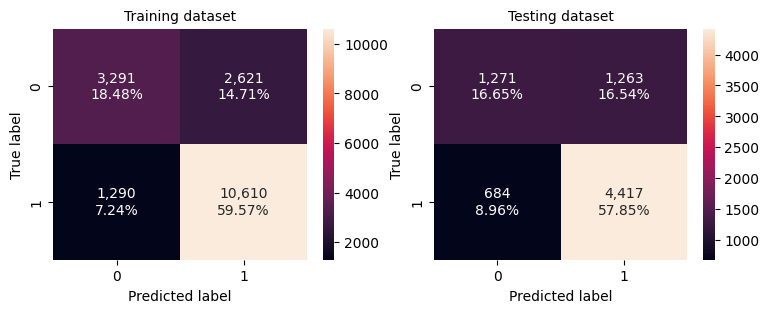

In [85]:
stacking_perf = model_performance(stacking, X_train, y_train, X_test, y_test, verbose=True)

In [86]:
# Choose the type of classifier.
stacking_tuned = StackingClassifier(estimators = [('rf', rf_tuned),
                                                  ('bagging', bagging_wt_tuned),
                                                  ('gbc', gbc_tuned)],
                                    final_estimator = abc_tuned)

stacking_tuned.fit(X_train, y_train) 

StackingClassifier(estimators=[('rf',
                                RandomForestClassifier(max_depth=9,
                                                       max_features='auto',
                                                       min_samples_leaf=5,
                                                       random_state=42)),
                               ('bagging',
                                BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight={0: 0.67,
                                                                                                      1: 0.33},
                                                                                        max_depth=1,
                                                                                        random_state=42),
                                                  n_estimators=50,
                                                  random_state=42)),
                               ('gbc',
                                GradientBoostingClassifier(n_estimators=50,
                                                           random_state=42))],
                   final_estimator=AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3),
                                                      learning_rate=0.01,
                                                      n_estimators=200,
                                                      random_state=42))

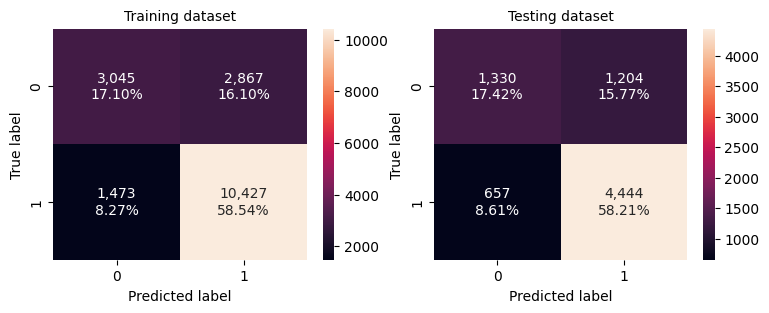

In [87]:
stacking_tuned_perf = model_performance(stacking_tuned, X_train, y_train, X_test, y_test, verbose=True)

* **A Tuned Stacking** model ranks second in terms of F1 score performance among the compared models.

## Model Performance Comparison and Conclusions

In [88]:
dtree_perf['model'] = 'Deccision Tree'
bagging_perf['model'] = 'Bagging'
bagging_wt_perf['model'] = 'Weighted Bagging'
rf_perf['model'] = 'Random Forest'
rf_wt_perf['model'] = 'Weighted Random Forest'
abc_perf['model'] = 'AdaBoost'
gbc_perf['model'] = 'Gradient Boosting'
xgb_perf['model'] = 'XGB'
dtree_tuned_perf['model'] = 'Deccision Tree - Tuned'
bagging_tuned_perf['model'] = 'Bagging - Tuned'
bagging_wt_tuned_perf['model'] = 'Weighted Bagging - Tuned'
rf_tuned_perf['model'] = 'Random Forest - Tuned'
rf_wt_tuned_perf['model'] = 'Weighted Random Forest - Tuned'
abc_tuned_perf['model'] = 'AdaBoost - Tuned'
gbc_tuned_perf['model'] = 'Gradient Boosting - Tuned'
xgb_tuned_perf['model'] = 'XGB - Tuned'
stacking_perf['model'] = 'Stacking'
stacking_tuned_perf['model'] = 'Stacking - Tuned'

In [89]:
models = pd.concat([dtree_perf, bagging_perf, bagging_wt_perf, rf_perf, rf_wt_perf,
                    abc_perf, gbc_perf, xgb_perf, dtree_tuned_perf, 
                    bagging_tuned_perf, bagging_wt_tuned_perf, rf_tuned_perf, 
                    rf_wt_tuned_perf,abc_tuned_perf, gbc_tuned_perf, xgb_tuned_perf,
                    stacking_perf, stacking_tuned_perf])

In [90]:
print("Training performance comparison:")
models.loc['Train'].set_index('model').style\
  .set_table_styles([dict(selector="th", 
                          props=[('min-width', '100px'),
                                 ('text-align', 'right')])]).format('{:.2%}')

Training performance comparison:


In [91]:
print("Testing performance comparison:")
models.loc['Test'].set_index('model').sort_values(by='F1', ascending=False).style\
  .set_table_styles([dict(selector="th", props=[('min-width', '100px'), 
                                                ('text-align', 'right')])])\
  .highlight_max(color = 'lightgreen', axis = 0).format('{:.2%}')

Testing performance comparison:


* The table above presents a performance comparison of various machine learning models for the visa approval problem. The F1 score was used as the primary metric for scoring, as it balances both precision and recall. Additional metrics used for comparison include accuracy, precision, recall, negative predictive value (NPV), and specificity.

* Based on the **`F1 score`**, the top 3 models are:
  1. XGB - Tuned (82.80%)
  2. Random Forest - Tuned (82.75%)
  3. Stacking - Tuned (82.69%)

* Based on the `Accuracy`, the best model is `Stacking - Tuned` (75.63%)

* Based on the `Recall`, the best model is `Weighted Bagging - Tuned` (93.65%)

* Based on the `Precision`, the best model is `Decison Tree - Tuned` (80.60%)

* When deciding on the best model for the visa approval problem, both model complexity and model robustness were taken into account.

  * **Model complexity** refers to the intricacy of a model's structure and its underlying mathematics. More complex models may require more computational resources and time, making them more challenging to deploy, maintain, and interpret. Simpler models, on the other hand, might be more interpretable and easier to maintain, which can be valuable in certain applications.
  * **Model robustness** relates to the model's ability to maintain its performance when there are changes in data distribution or when exposed to new and unseen data. Some models may be more sensitive to such changes, making them less reliable in real-world scenarios. In contrast, more robust models can generalize better, providing more consistent and reliable predictions.


## **Plotting the feature importance of each variable**

In [101]:
pd.concat([pd.DataFrame(xgb_tuned.feature_importances_,
                        columns = ["XGB - Tuned"], index = X_train.columns),
           pd.DataFrame(rf_tuned.feature_importances_,
                        columns = ["Random Forest - Tuned"], index = X_train.columns),
           pd.DataFrame(rf_tuned.feature_importances_,
                        columns = ["Stacking - Tuned"], index = X_train.columns)],
           axis=1).sort_values(by = 'XGB - Tuned', ascending = False).style\
          .set_table_styles([dict(selector="th", 
                                  props=[('min-width', '100px'), 
                                         ('text-align', 'right')])])\
          .highlight_max(color = 'lightgreen', axis = 0).format('{:.2%}')

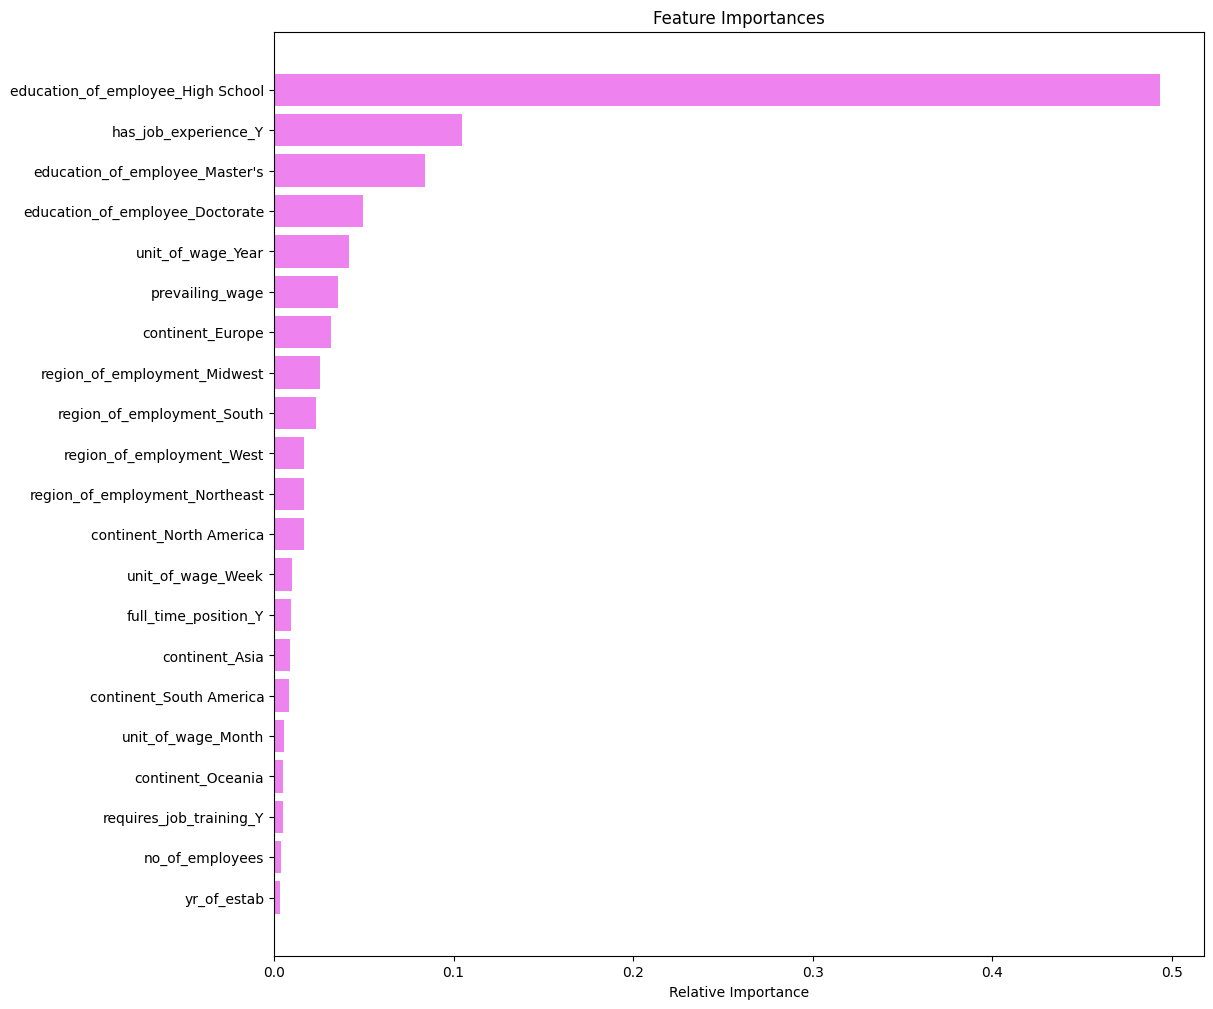

In [102]:
feature_names = X_train.columns
importances = xgb_tuned.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)),
         importances[indices], color='violet', 
         align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

**Let's visualize the tuned decision tree to better understand how variables impact the results. This will allow us to visually explore the decision-making process of the model and confirm which features are most important in making predictions.**

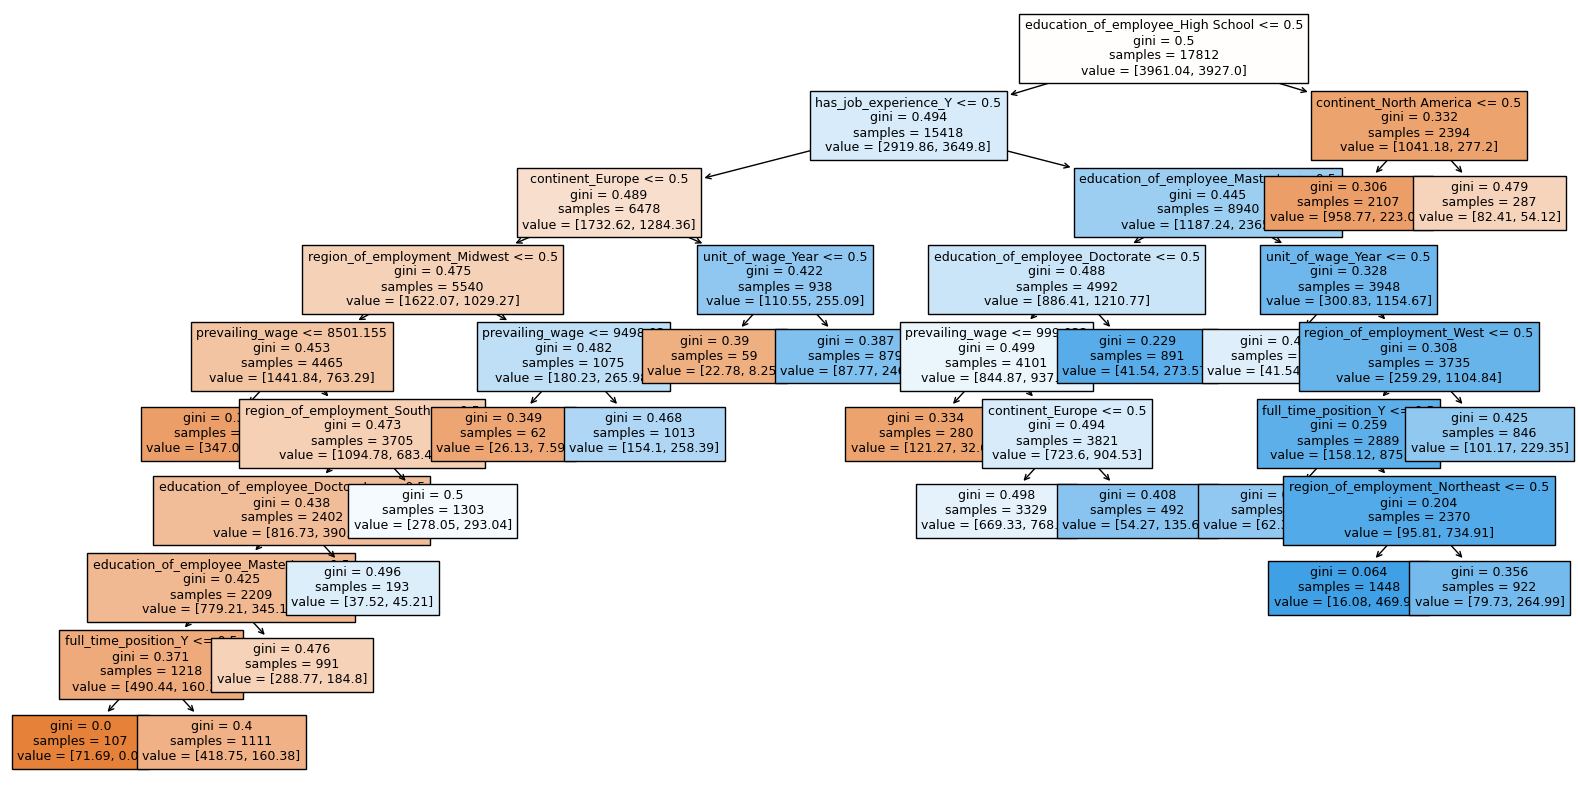

In [103]:
plt.figure(figsize=(20, 10))

out = tree.plot_tree(
    dtree_tuned,
    feature_names=feature_names,
    filled=True,
    fontsize=9,
    node_ids=False,
    class_names=None,
)
for o in out:
    arrow = o.arrow_patch
    if arrow is not None:
        arrow.set_edgecolor("black")
        arrow.set_linewidth(1)
plt.show()

**We can interpret the impact of individual variables on the predicted outcome by building a logistic regression model. This will provide coefficients for each input variable, helping us understand which variables are most important for predictions. We can then compare these coefficients with the decision tree visualization to better interpret the decision-making process of both models.**

In [104]:
lr = sm.Logit(y_train, X_train).fit()
print(lr.summary())

Optimization terminated successfully.
         Current function value: 0.535258
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:            case_status   No. Observations:                17812
Model:                          Logit   Df Residuals:                    17791
Method:                           MLE   Df Model:                           20
Date:                Sat, 15 Apr 2023   Pseudo R-squ.:                  0.1578
Time:                        07:36:50   Log-Likelihood:                -9534.0
converged:                       True   LL-Null:                       -11320.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
no_of_employees                   -1.961e-07    7.4e-07     -0

In [105]:
# converting coefficients to odds
odds = np.exp(lr.params)

# finding the percentage change
perc_change_odds = (np.exp(lr.params) - 1) * 100

# adding the odds to a dataframe
pd.DataFrame({"Odds": odds, "Change_odd%": perc_change_odds}, index=X_train.columns).loc[["education_of_employee_High School",  
                                                                                          "prevailing_wage",
                                                                                          "education_of_employee_Master's",
                                                                                          "has_job_experience_Y",
                                                                                          "education_of_employee_Doctorate",
                                                                                          "unit_of_wage_Year"
                                                                                          ]]

Odds  Change_odd%
education_of_employee_High School  0.272523   -72.747705
prevailing_wage                    1.000000     0.000029
education_of_employee_Master's     2.380927   138.092708
has_job_experience_Y               2.424200   142.419997
education_of_employee_Doctorate    4.048728   304.872752
unit_of_wage_Year                  3.221548   222.154839

* `education_of_employee_High School`: Holding all other variables constant, the odds of a visa being certified for an employee with a high school education are about **72.7%** lower compared to employees with a Bachelor's degree, assuming a linear relationship between `prevailing_wage` and the log odds of visa certification `case_status`.

* `education_of_employee_Master's`: Holding all other variables constant, the odds of a visa being certified for an employee with a Master's degree are about *138%* higher compared to employees with a Bachelor's degree.

* `prevailing_wage`: Holding all other features constant, each 100,000 units increase in `prevailing_wage` will increase the odds that the visa will be certified by approximately **2.9%**

* `has_job_experience_Y`: Holding all other variables constant, the odds of a visa being certified for an employee with job experience are about **142.4%** higher compared to the employees with no job experience.

<br>**NB:** *The linear relationship between the explanatory variable and the Logit of the response variable has not been verified! The interpretation of the model may not be accurate. Therefore, it should be used only as a tool to understand the direction of the variable's impact, rather than as a precise predictor of the response.*

## Actionable Insights and Recommendations

> After analyzing the data and evaluating the performance of various machine learning models, here are some actionable insights and recommendations to improve the visa approval process and make data-driven decisions:

* **Key features identification**. Based on feature importance analysis from the top-performing models, we determined the most significant factors that influence visa approvals. These factors include:
  * Employee has **High School** or **Masters education**
  * Employee has **job experience**
  * Level of **prevailing wage** (for some models)

* **Focus on high-performing models**. We recommend to utilize the top-performing models, such as:
  * **XGB - Tuned**,
  * **Random Forest - Tuned**, and
  * **Stacking - Tuned**,<br>
  for the visa approval process. These models demonstrate a good balance between precision and recall, minimizing both false negatives and false positives.

* **Be up-to-date**. We recommend continuously monitor and update the model. As new data becomes available, update and retrain the selected model to maintain its accuracy and relevance to current trends. This will ensure that the model stays robust and effective in predicting visa approvals.

> Recommended **profile for the applicants** for whom the visa should be certified or denied based on the drivers that significantly influence the case status.

* Based on the analysis, the profile of applicants for whom the visa status is more likely to be **approved** is as follows:
  * Applicants with at least a Bachelor's degree have higher odds of visa approval, with those holding Master's and Doctorate degrees being preferred.
  * Applicants with job experience have higher odds of visa approval compared to those without job experience.
  * It is likely that applicants with a prevailing wage around 72,500 (see EDA above) may have higher odds of visa approval.

* The profile of applicants more likely to have their visa **denied** is as follows:
  * Applicants with lower education levels, such as a high school diploma, have lower odds of visa approval compared to those with higher education levels, like Bachelor's, Master's, or Doctorate degrees.
  * Applicants without job experience have lower odds of visa approval compared to those with job experience.
  * Applicants with a prevailing wage around 65,500, which is lower than the median prevailing wage of approved visas (around 72,500), may have lower odds of visa approval.

In [97]:
#!jupyter nbconvert --to html /content/project_5_at.ipynb